# __Accompanying notebook for: Velocity Measurements of Powdered Rock at Low Confining Pressures and Comparison to Lunar Shallow Seismic Velocity__

_Chance Amos, Manika Prasad, Kevin Cannon, Chris Dreyer_<br>
_Colorado School of Mines_<br>


## Load Libraries and Data

In [1]:
import rputils as rp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import HTML
import json
import pandas as pd
from scipy import integrate, optimize
from scipy.fft import rfft, rfftfreq
from scipy.ndimage import gaussian_filter

from decimal import Decimal
import matplotlib.ticker as mticker
def sci_format_short(x,lim):
    return '{:.0e}'.format(x)
major_formatter1 = mticker.FuncFormatter(sci_format_short)
def sci_format_alt(x,lim):
    return '{:.1e}'.format(Decimal(x))
major_formatter2 = mticker.FuncFormatter(sci_format_alt)
# def int_format(x,lim):
#     return lambda x, p: format(int(x), ',')
# major_formatter3 = mticker.FuncFormatter(int_format)

## Define consistent color to use for the 4 pressure steps
pres_colors = ["dimgray", "brown", "royalblue", "darkgoldenrod"]
pressures = [0.000005, 0.00003, 0.000055, 0.00008] # in GPa

In [2]:
"""
Load all data
"""
## Particle size distribution
data_path = "../data/grain_size/LHT-1g_ParticleSize.txt"
particle_data = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/grain_size/LHT-1g_Rebin-to-15301.txt"
particle_data_rebin = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/grain_size/Apollo_15301.txt"
apollo_15_data = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/grain_size/Apollo_64501.txt"
apollo_64501_data = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/grain_size/Apollo_67461.txt"
apollo_67461_data = np.genfromtxt(data_path, skip_header=1)


## Mineral data
with open("../data/mineral_data.txt", "r") as f:
    min_dict = json.load(f)

## Velocity data
## Data loads as [sample number, (vp, bulk density, porosity)]
data_path = "../data/velocity_picks/0_ice_vp.txt"
data_p = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/velocity_picks/0_ice_vs.txt"
data_s = np.genfromtxt(data_path, skip_header=1)


## Pressure-velocity data
## Data loads as [sample number, (vp, bulk density, porosity, pressure (MPa))]
data_path = "../data/velocity_picks/0_ice_vp_pressure.txt"
data_pressure_p = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/velocity_picks/0_ice_vs_pressure.txt"
data_pressure_s = np.genfromtxt(data_path, skip_header=1)

pres_step_0_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[3]*1000,3))]

pres_step_0_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[3]*1000,3))]


##----------------
## NOTE: since this data is taken from publications, it will not be included in this repo

## Lab velocities from Johnson et al. 1982, "Compressional wave velocities of a lunar regolith 
## sample in a simulated lunar environment"
johnson_path = "../data/Johnson_Apollo_Lab.txt"
johnson_data = np.genfromtxt(johnson_path, dtype=np.float32, skip_header=6, encoding='utf-8')
johnson_data[:,2] = johnson_data[:,2] /10  #convert Bar to MPa

## Lab velocities from Talwani et al. 1974, "Implications of elastic wave velocities for Apollo 
## 17 rock powders" at 1 bar (0.1 MPa)
talwani_path = "../data/Talwani_vpvs.txt"
talwani_data = np.genfromtxt(talwani_path, dtype=np.float32, skip_header=5, encoding='utf-8')
talwani_vp = talwani_data[:,0]
talwani_vs = talwani_data[:,1]
talwani_pressure = [0.]*len(talwani_vp)  # MPa

## Dry sand velocities from Prasad 2002
prasad_path = "../data/Prasad_Sands.txt"
prasad_data = np.genfromtxt(prasad_path, dtype=np.float32, skip_header=1, encoding="utf-8")
prasad_pres = prasad_data[:,1]
prasad_por = prasad_data[:,2]
prasad_vp = prasad_data[:,3]
prasad_vs = prasad_data[:,4]
prasad_class = prasad_data[:,5]  #class 1:round, 2:angular, 3:silt

## Data Plots

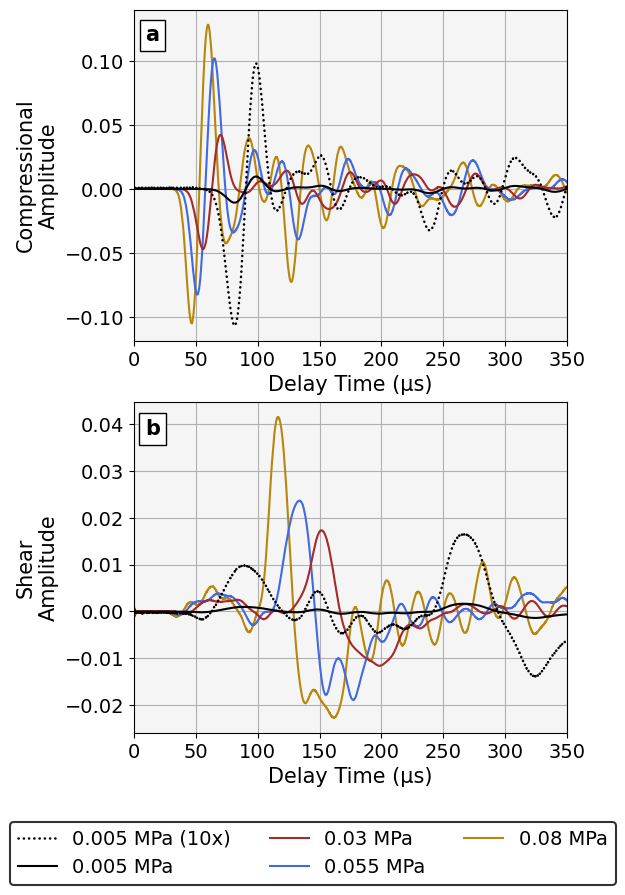

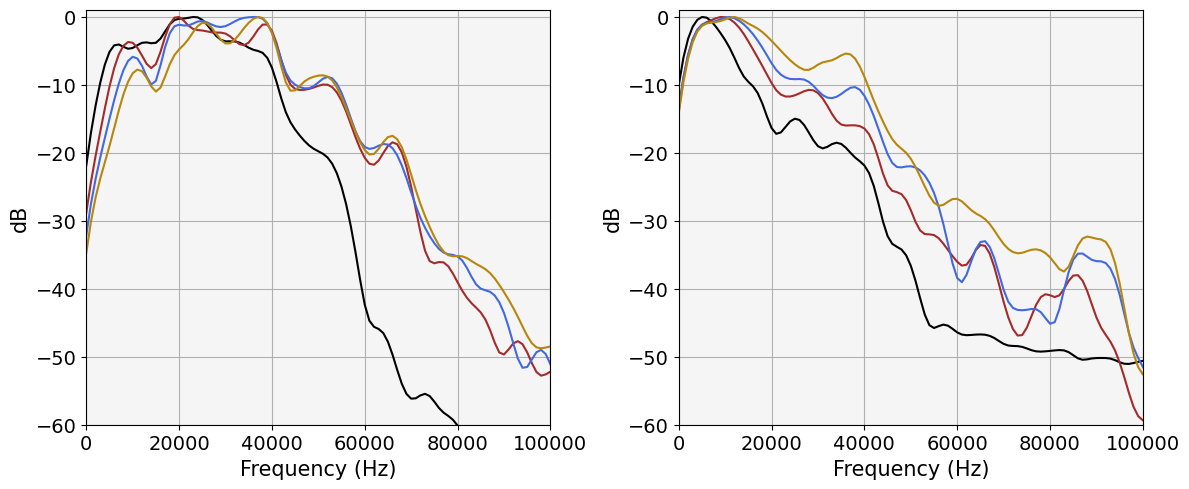

In [13]:
"""
Plot examples of raw waveforms
"""

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Data paths

p0_path = "../data/raw_waves/P_waves/0_ice_granular/Pressure/3_P_0i_13-92mm_19-01g_P000_0000.asc"
p1_path = "../data/raw_waves/P_waves/0_ice_granular/Pressure/3_2kg_P_0i_13-38mm_19-01g_P000_0000.asc"
p2_path = "../data/raw_waves/P_waves/0_ice_granular/Pressure/3_4kg_P_0i_13-21mm_19-01g_P000_0000.asc"
p3_path = "../data/raw_waves/P_waves/0_ice_granular/Pressure/3_6kg_P_0i_13-17mm_19-01g_P000_0000.asc"

s0_path = "../data/raw_waves/S_waves/0_ice_granular/Pressure/1_S_0i_16-82mm_24-74g_P000_0000.asc"
s1_path = "../data/raw_waves/S_waves/0_ice_granular/Pressure/1_2kg_S_0i_16-54mm_24-74g_P000_0000.asc"
s2_path = "../data/raw_waves/S_waves/0_ice_granular/Pressure/1_4kg_S_0i_16-38mm_24-74g_P000_0000.asc"
s3_path = "../data/raw_waves/S_waves/0_ice_granular/Pressure/1_6kg_S_0i_16-31mm_24-74g_P000_0000.asc"


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Load saved waveforms
wavep0, wavep0_header = rp.jsl.load_waveform(p0_path, return_header=True)
wavep1, wavep1_header = rp.jsl.load_waveform(p1_path, return_header=True)
wavep2, wavep2_header = rp.jsl.load_waveform(p2_path, return_header=True)
wavep3, wavep3_header = rp.jsl.load_waveform(p3_path, return_header=True)

waves0, waves0_header = rp.jsl.load_waveform(s0_path, return_header=True)
waves1, waves1_header = rp.jsl.load_waveform(s1_path, return_header=True)
waves2, waves2_header = rp.jsl.load_waveform(s2_path, return_header=True)
waves3, waves3_header = rp.jsl.load_waveform(s3_path, return_header=True)

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## P DATA
## Grab time values, optionally smooth amplitudes
smoother = None  # None for no smoothing

wavep0_time = wavep0[0,:] / 1e3
wavep1_time = wavep1[0,:] / 1e3
wavep2_time = wavep2[0,:] / 1e3
wavep3_time = wavep3[0,:] / 1e3
    
wavep0_amp = wavep0[1,:]
wavep1_amp = wavep1[1,:]
wavep2_amp = wavep2[1,:]
wavep3_amp = wavep3[1,:]
if smoother is not None:
    wavep0_amp = rp.filters.median(wavep0_amp, size=smoother)
    wavep1_amp = rp.filters.median(wavep1_amp, size=smoother)
    wavep2_amp = rp.filters.median(wavep2_amp, size=smoother)
    wavep3_amp = rp.filters.median(wavep3_amp, size=smoother)


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## S DATA
## Grab time values, optionally smooth amplitudes
smoother = None  # None for no smoothing

waves0_time = waves0[0,:] / 1e3
waves1_time = waves1[0,:] / 1e3
waves2_time = waves2[0,:] / 1e3
waves3_time = waves3[0,:] / 1e3
    
waves0_amp = waves0[1,:]
waves1_amp = waves1[1,:]
waves2_amp = waves2[1,:]
waves3_amp = waves3[1,:]
if smoother is not None:
    waves0_amp = rp.filters.median(waves0_amp, size=smoother)
    waves1_amp = rp.filters.median(waves1_amp, size=smoother)
    waves2_amp = rp.filters.median(waves2_amp, size=smoother)
    waves3_amp = rp.filters.median(waves3_amp, size=smoother)


    
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## PLOTS

## Plot waveforms
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,9))
xlims=(0, 350)
amp_multiplier = 10

ax[0].plot(wavep3_time, wavep3_amp, label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3])
ax[0].plot(wavep2_time, wavep2_amp, label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2])
ax[0].plot(wavep1_time, wavep1_amp, label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1])
ax[0].plot(wavep0_time, wavep0_amp, label=str(round(pressures[0]*1000,3))+" MPa", color="black")
ax[0].plot(wavep0_time, wavep0_amp*amp_multiplier, label=str(round(pressures[0]*1000,3))+" MPa", color="black", 
           ls=(0, (0.1, 2)), lw=1.8, dash_capstyle = "round")
ax[0].grid("both")
ax[0].set(# xlabel="Time (ns)",
          xlim=(xlims[0],xlims[1]),
          yscale="linear",
          facecolor="whitesmoke")
ax[0].tick_params(axis='both', labelsize=14)
# ax[0].legend(loc="upper right", fontsize=8)
ax[0].set_ylabel("Compressional\nAmplitude", fontsize=15)
ax[0].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[0].text(15, 0.12, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[1].plot(waves3_time, waves3_amp, label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3])
ax[1].plot(waves2_time, waves2_amp, label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2])
ax[1].plot(waves1_time, waves1_amp, label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1])
ax[1].plot(waves0_time, waves0_amp, label=str(round(pressures[0]*1000,3))+" MPa", color="black")
ax[1].plot(waves0_time, waves0_amp*amp_multiplier, label=str(round(pressures[0]*1000,3))+" MPa (10x)", color="black", 
           ls=(0, (0.1, 2)), lw=1.8, dash_capstyle = "round")
ax[1].grid("both")
ax[1].set(xlim=(xlims[0],xlims[1]),
          yscale="linear",
         facecolor="whitesmoke")
ax[1].tick_params(axis='both', labelsize=14)
# ax[1].legend(loc="upper right", fontsize=12, bbox_to_anchor=[1, 1.25], framealpha=1, edgecolor="black", ncol=2)
ax[1].set_ylabel("Shear\nAmplitude", fontsize=15)
ax[1].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[1].text(15, 0.039, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


handles, labels = ax[1].get_legend_handles_labels()
legend = fig.legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.02, 0.0, 1., 1), ncols=3, 
           loc='lower center', fontsize=14)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")
plt.tight_layout()
plt.subplots_adjust(bottom=0.18)

plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig4_waveforms.jpg", dpi=1000, bbox_inches = "tight")
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig4_waveforms.pdf", dpi=600, bbox_inches="tight")



## Plot the frequency spectra, -50 to +150 microseconds from peak energy
p_sample_rate = 1 / float(wavep0_header['delta t (s)'])
s_sample_rate = 1 / float(waves0_header['delta t (s)'])

p_freqs = rfftfreq(len(wavep0_amp), 1 / p_sample_rate)
s_freqs = rfftfreq(len(waves0_amp), 1 / s_sample_rate)

# p0_scaler, s0_scaler = StandardScaler(), StandardScaler()
# p1_scaler, s1_scaler = StandardScaler(), StandardScaler()
# p2_scaler, s2_scaler = StandardScaler(), StandardScaler()
# p3_scaler, s3_scaler = StandardScaler(), StandardScaler()
# p0_spectra = np.abs(rfft(np.squeeze(p0_scaler.fit_transform(np.expand_dims(wavep0_amp, axis=-1)))))
# p1_spectra = np.abs(rfft(np.squeeze(p1_scaler.fit_transform(np.expand_dims(wavep1_amp, axis=-1)))))
# p2_spectra = np.abs(rfft(np.squeeze(p2_scaler.fit_transform(np.expand_dims(wavep2_amp, axis=-1)))))
# p3_spectra = np.abs(rfft(np.squeeze(p3_scaler.fit_transform(np.expand_dims(wavep3_amp, axis=-1)))))
# s0_spectra = np.abs(rfft(np.squeeze(s0_scaler.fit_transform(np.expand_dims(waves0_amp, axis=-1)))))
# s1_spectra = np.abs(rfft(np.squeeze(s1_scaler.fit_transform(np.expand_dims(waves1_amp, axis=-1)))))
# s2_spectra = np.abs(rfft(np.squeeze(s2_scaler.fit_transform(np.expand_dims(waves2_amp, axis=-1)))))
# s3_spectra = np.abs(rfft(np.squeeze(s3_scaler.fit_transform(np.expand_dims(waves3_amp, axis=-1)))))

p0_spectra = np.abs(rfft(wavep0_amp))
p1_spectra = np.abs(rfft(wavep1_amp))
p2_spectra = np.abs(rfft(wavep2_amp))
p3_spectra = np.abs(rfft(wavep3_amp))

s0_spectra = np.abs(rfft(waves0_amp))
s1_spectra = np.abs(rfft(waves1_amp))
s2_spectra = np.abs(rfft(waves2_amp))
s3_spectra = np.abs(rfft(waves3_amp))

gaussian_sigma = 2
p0_spectra = gaussian_filter(p0_spectra, sigma=gaussian_sigma, mode='nearest')
p1_spectra = gaussian_filter(p1_spectra, sigma=gaussian_sigma, mode='nearest')
p2_spectra = gaussian_filter(p2_spectra, sigma=gaussian_sigma, mode='nearest')
p3_spectra = gaussian_filter(p3_spectra, sigma=gaussian_sigma, mode='nearest')

s0_spectra = gaussian_filter(s0_spectra, sigma=gaussian_sigma, mode='nearest')
s1_spectra = gaussian_filter(s1_spectra, sigma=gaussian_sigma, mode='nearest')
s2_spectra = gaussian_filter(s2_spectra, sigma=gaussian_sigma, mode='nearest')
s3_spectra = gaussian_filter(s3_spectra, sigma=gaussian_sigma, mode='nearest')

p0_spectra = 20 * np.log10(p0_spectra/np.amax(p0_spectra))
p1_spectra = 20 * np.log10(p1_spectra/np.amax(p1_spectra))
p2_spectra = 20 * np.log10(p2_spectra/np.amax(p2_spectra))
p3_spectra = 20 * np.log10(p3_spectra/np.amax(p3_spectra))

s0_spectra = 20 * np.log10(s0_spectra/np.amax(s0_spectra))
s1_spectra = 20 * np.log10(s1_spectra/np.amax(s1_spectra))
s2_spectra = 20 * np.log10(s2_spectra/np.amax(s2_spectra))
s3_spectra = 20 * np.log10(s3_spectra/np.amax(s3_spectra))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
freq_lims = (0, 1e5)
db_lims = (-60, 1)
ax[0].plot(p_freqs, p0_spectra, color="black")
ax[0].plot(p_freqs, p1_spectra, color=pres_colors[1])
ax[0].plot(p_freqs, p2_spectra, color=pres_colors[2])
ax[0].plot(p_freqs, p3_spectra, color=pres_colors[3])
ax[0].set(xlim=(freq_lims[0],freq_lims[1]),
          ylim=(db_lims[0], db_lims[1]),
          facecolor="whitesmoke")
ax[0].grid("both")
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_xlabel("Frequency (Hz)", fontsize=15)
ax[0].set_ylabel("dB", fontsize=15)

ax[1].plot(s_freqs, s0_spectra, color="black")
ax[1].plot(s_freqs, s1_spectra, color=pres_colors[1])
ax[1].plot(s_freqs, s2_spectra, color=pres_colors[2])
ax[1].plot(s_freqs, s3_spectra, color=pres_colors[3])
ax[1].set(xlim=(freq_lims[0],freq_lims[1]),
          ylim=(db_lims[0], db_lims[1]),
          facecolor="whitesmoke")
ax[1].grid("both")
ax[1].tick_params(axis='both', labelsize=14)
ax[1].set_xlabel("Frequency (Hz)", fontsize=15)
ax[1].set_ylabel("dB", fontsize=15)

plt.tight_layout()
plt.show()

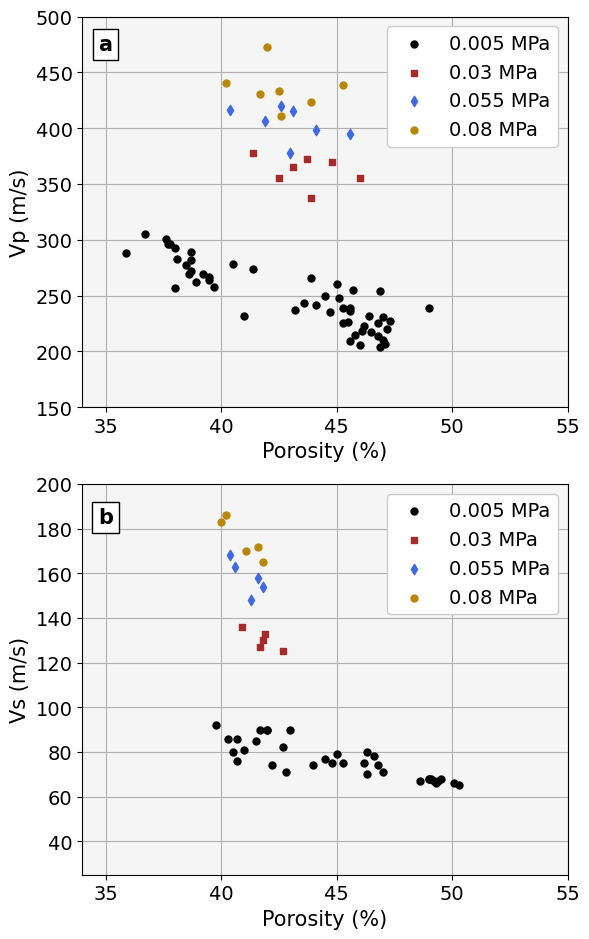

In [12]:
"""
Plot measured Vp and Vs data
"""

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,9.5))
xlims = (34, 55)
dot_size = 25

ax[0].scatter(pres_step_0_p[:,2]*100, pres_step_0_p[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0].scatter(pres_step_1_p[:,2]*100, pres_step_1_p[:,0], s=dot_size, color=pres_colors[1], marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[0].scatter(pres_step_2_p[:,2]*100, pres_step_2_p[:,0], s=dot_size+3, color=pres_colors[2], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0].scatter(pres_step_3_p[:,2]*100, pres_step_3_p[:,0], s=dot_size, color=pres_colors[3],
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[0].scatter(data_p[:,2]*100, data_p[:,0], s=dot_size, color="black")
ax[0].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,500),
         # xlabel="Porosity (%)",
         # ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].set_xlabel("Porosity (%)", fontsize=15)
ax[0].set_ylabel("Vp (m/s)", fontsize=15)
ax[0].legend(loc="upper right", fontsize=14, framealpha=1)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].text(35, 475, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0].grid("both")

ax[1].scatter(pres_step_0_s[:,2]*100, pres_step_0_s[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1].scatter(pres_step_1_s[:,2]*100, pres_step_1_s[:,0], s=dot_size, color=pres_colors[1], marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[1].scatter(pres_step_2_s[:,2]*100, pres_step_2_s[:,0], s=dot_size+3, color=pres_colors[2], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1].scatter(pres_step_3_s[:,2]*100, pres_step_3_s[:,0], s=dot_size, color=pres_colors[3],
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[1].scatter(data_s[:,2]*100, data_s[:,0], s=dot_size, color="black")
ax[1].set(xlim=(xlims[0], xlims[1]),
         ylim=(25,200),
         # xlabel="Porosity (%)",
         # ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].set_xlabel("Porosity (%)", fontsize=15)
ax[1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1].legend(loc="upper right", fontsize=14, framealpha=1)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].text(35, 185, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1].grid("both")

plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig5_data_plot.jpg", dpi=1000)
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig5_data_plot.pdf", dpi=600, bbox_inches="tight")

## Calculate an Effective Mineral

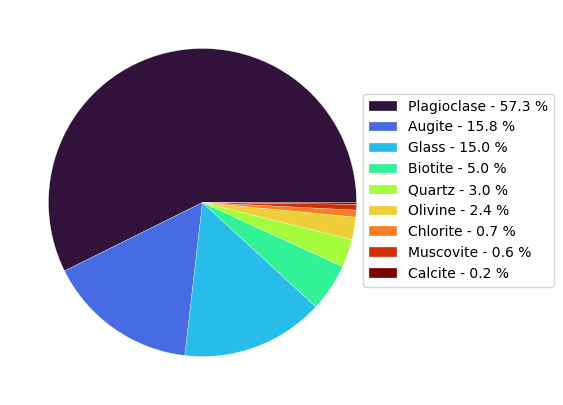

Constituent,Volume Fraction,Bulk Modulus (GPa),Shear Modulus (GPa),Density (g/cm3),P-Velocity (m/s),S-Velocity (m/s),Source
Plagioclase,0.573,84.2,39.9,2.73,7094,3823,"Hearmon, 1984"
Augite,0.158,95.0,59.0,3.26,7298,4254,"Bass, 2013"
Glass,0.15,69.2,38.7,2.69,6701,3792,"Wang, 1989"
Biotite,0.05,59.7,42.3,3.05,6169,3724,"Mavko et al., 2020"
Quartz,0.03,37.9,44.3,2.65,6049,4088,"McSkimin et al., 1965"
Olivine,0.024,130.0,80.0,3.32,8443,4908,"Carmichael, 1989"
Chlorite,0.007,164.3,81.9,2.84,9813,5370,"Wang et al., 2001"
Muscovite,0.006,58.2,41.1,2.79,6364,3838,"Vaughan & Guggenheim, 1986"
Calcite,0.002,76.8,32.0,2.71,6639,3436,"Simmons & Wang, 1971"
Effective Mineral,1,80.9,43.5,2.98,6827,3819,


In [16]:
"""
Calculate effective mineral properties based on major 
mineral constituents of LHT-1g

Top 9 minerals were used from lab volume analysis,
representing 96.7% of total volume

k: bulk modulus, u: shear modulus
f: volume fraction, d: density
"""

## Keep this same order in the lists below
minerals = min_dict["minerals"]


## Gather mineral values into lists, use mineral order from above
min_volume_fractions = min_dict["min_volume_fractions"]
min_bulk_mods = min_dict["min_bulk_mods"]
min_shear_mods = min_dict["min_shear_mods"]
min_densities = min_dict["min_densities"]
min_pvels = [rp.elastic.p_vel(k,u,d) for k,u,d in zip(min_bulk_mods, min_shear_mods, min_densities)]
min_svels = [rp.elastic.s_vel(u,d) for u,d in zip(min_shear_mods, min_densities)]
min_vpvs = [p/s for p, s in zip(min_pvels, min_svels)]


## Calculate effective properties
## Note: difference between Hill Average and HS lower is minimal in this case
## Hill Average and HS average produce identical results
_kL, _uL = rp.bounds.hs('lower', min_volume_fractions, min_bulk_mods, min_shear_mods)
_kU, _uU = rp.bounds.hs('upper', min_volume_fractions, min_bulk_mods, min_shear_mods)
effective_mineral_k, effective_mineral_u = np.mean((_kL, _kU)), np.mean((_uL, _uU))
# eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])
eff_min_density = 2.98  ## override calculation w/ measured value
eff_min_vp = rp.elastic.p_vel(effective_mineral_k, effective_mineral_u, eff_min_density)
eff_min_vs = rp.elastic.s_vel(effective_mineral_u, eff_min_density)
eff_min_vpvs = eff_min_vp/eff_min_vs
poisson_grain = rp.elastic.poisson_mod(effective_mineral_k, effective_mineral_u)

## Pie chart of mineral constituents
n_colors = len(minerals)
plot_colors = plt.cm.turbo(np.linspace(0.,1.,n_colors))

plt.figure(figsize=(5,5))
pie, _ = plt.pie(min_volume_fractions, colors=plot_colors,
                wedgeprops={"edgecolor":"white", "linewidth":0.2})
pie_labels = [f'{i} - {j*100:.1f} %' for i,j in zip(minerals, min_volume_fractions)]
plt.legend(pie, pie_labels, bbox_to_anchor=(0.9, 0.8),fontsize=10)
plt.show()


## Table of constituent properties
sources = ["Hearmon, 1984", "Bass, 2013", "Wang, 1989", "Mavko et al., 2020", "McSkimin et al., 1965",
          "Carmichael, 1989", "Wang et al., 2001", "Vaughan & Guggenheim, 1986", "Simmons & Wang, 1971"]
table_data=[]
for _ in range(len(minerals)):
    tmp_list = []
    tmp_list.append(minerals[_])
    tmp_list.append(round(min_volume_fractions[_],3))
    tmp_list.append(round(min_bulk_mods[_],1))
    tmp_list.append(round(min_shear_mods[_],1))
    tmp_list.append(round(min_densities[_],2))
    tmp_list.append(int(min_pvels[_]*1000))
    tmp_list.append(int(min_svels[_]*1000))
    # tmp_list.append(round(min_vpvs[_],2))
    tmp_list.append(sources[_])
    table_data.append(tmp_list)
eff_print_list = []
eff_print_list.append("Effective Mineral")
eff_print_list.append("1")
eff_print_list.append(round(effective_mineral_k,1))
eff_print_list.append(round(effective_mineral_u,1))
eff_print_list.append(round(eff_min_density,2))
eff_print_list.append(int(eff_min_vp*1000))
eff_print_list.append(int(eff_min_vs*1000))
# eff_print_list.append(round(eff_min_vpvs,2))
table_data.append(eff_print_list)
    
table_df = pd.DataFrame(table_data, columns=['Constituent', 'Volume Fraction','Bulk Modulus (GPa)',
                                            'Shear Modulus (GPa)', 'Density (g/cm3)',
                                            'P-Velocity (m/s)', 'S-Velocity (m/s)',
                                            'Source'])
table_df.fillna("",inplace=True)
table_df = table_df.to_html(index=False)

HTML(table_df)


## Particle Size Distribution

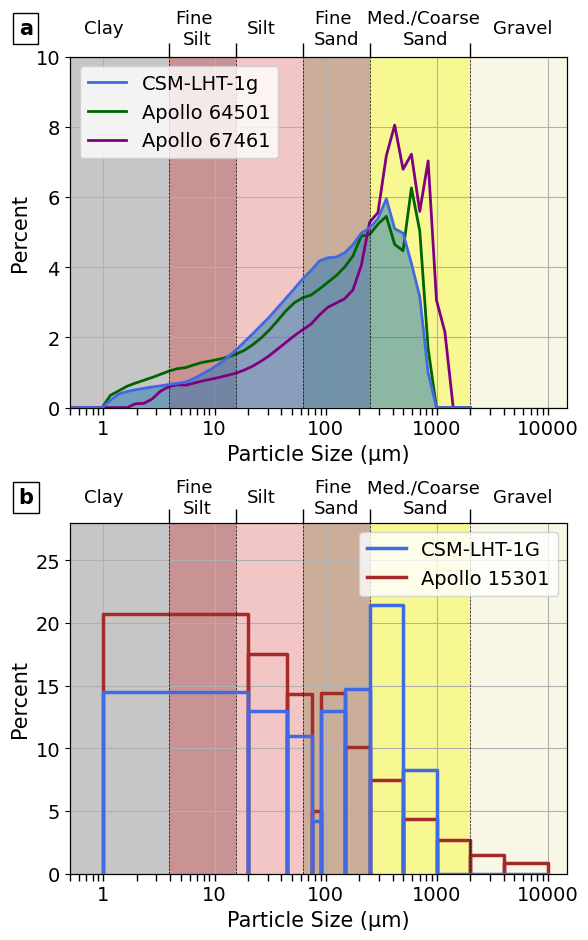

In [11]:
"""
Plot particle size distribution from LHT-1G, compare to Apollo.

Grain size classes shown are from the Wentworth (1922) scale.
"""

## LHT-1g
particle_sizes = particle_data[:,0]
particle_percents = particle_data[:,1]
particle_cumulative = particle_data[:,2]
particle_mean_bin = (np.abs(particle_cumulative - 50)).argmin()
particle_mean = particle_sizes[particle_mean_bin]

## Apollo 64501
ap_64501_sizes = apollo_64501_data[:,0]
ap_64501_percents = apollo_64501_data[:,1]
ap_64501_cumulative = apollo_64501_data[:,2]
ap_64501_mean_bin = (np.abs(ap_64501_cumulative - 50)).argmin()
ap_64501_mean = ap_64501_sizes[ap_64501_mean_bin]

## Apollo 67461
ap_67461_sizes = apollo_67461_data[:,0]
ap_67461_percents = apollo_67461_data[:,1]
ap_67461_cumulative = apollo_67461_data[:,2]
ap_67461_mean_bin = (np.abs(ap_67461_cumulative - 50)).argmin()
ap_67461_mean = ap_67461_sizes[ap_67461_mean_bin]

## Apollo sample 15301
apollo_particle_sizes = np.flip(apollo_15_data[:,0])
apollo_particle_percents = np.flip(apollo_15_data[:,1])
ap_plot_sizes = np.copy(apollo_particle_sizes)
ap_plot_percents = np.copy(apollo_particle_percents)
ap_plot_sizes = np.repeat(ap_plot_sizes, 2)
ap_plot_sizes = ap_plot_sizes[1:]
ap_plot_percents = np.repeat(ap_plot_percents, 2)
ap_plot_percents = ap_plot_percents[:-1]
ap_plot_sizes = np.insert(ap_plot_sizes, 0, ap_plot_sizes[0])
ap_plot_percents = np.insert(ap_plot_percents, 0, 0)
rep_idxs = np.arange(3,23,2)
rep_idxs_flip = np.flip(rep_idxs)
size_rep = np.ones(len(ap_plot_sizes)).astype("int8")
size_rep[rep_idxs] = 2
for i in rep_idxs_flip:
    ap_plot_percents = np.insert(ap_plot_percents, i, 0)
ap_plot_sizes = np.repeat(ap_plot_sizes, size_rep)

## Rebinned LHT-1g
rebin_particle_sizes = np.flip(particle_data_rebin[:,0])
rebin_particle_percents = np.flip(particle_data_rebin[:,1])
rebin_plot_sizes = np.copy(rebin_particle_sizes)
rebin_plot_percents = np.copy(rebin_particle_percents)
rebin_plot_sizes = np.repeat(rebin_plot_sizes, 2)
rebin_plot_sizes = rebin_plot_sizes[1:]
rebin_plot_percents = np.repeat(rebin_plot_percents, 2)
rebin_plot_percents = rebin_plot_percents[:-1]
rebin_plot_sizes = np.insert(rebin_plot_sizes, 0, rebin_plot_sizes[0])
rebin_plot_percents = np.insert(rebin_plot_percents, 0, 0)
rep_idxs = np.arange(3,23,2)
rep_idxs_flip = np.flip(rep_idxs)
size_rep = np.ones(len(rebin_plot_sizes)).astype("int8")
size_rep[rep_idxs] = 2
for i in rep_idxs_flip:
    rebin_plot_percents = np.insert(rebin_plot_percents, i, 0)
rebin_plot_sizes = np.repeat(rebin_plot_sizes, size_rep)


## From Wentworth scale, in microns
particle_boundaries=[3.9, 15.6, 63, 250, 2000, 20e3]

grain_colors = ["gray", "darkred", "lightcoral", "saddlebrown", "yellow", "lemonchiffon"]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 9.5))
# xlims=(2**-1, 12.5**3)
xlims=(5e-1, 15e3)
zorder = 5

# ## Cumulative plot
# plot_cumulative = False
# if plot_cumulative:
#     twinx = ax.twinx()
#     cumu_plot = twinx.plot(particle_sizes, particle_cumulative, color="brown", zorder=zorder+3)
#     twinx.yaxis.label.set_color(cumu_plot[0].get_color())
#     twinx.set_ylabel("Cumulative", rotation=270)
#     twinx.set(ylim=(0, 101),
#               xlim=(xlims[0], xlims[1]),
#               xscale=("log"))

## Percents bar plot
ax[0].plot(particle_sizes, particle_percents, color="royalblue", label="CSM-LHT-1g", linewidth=2, zorder=50)
ax[0].fill_between(particle_sizes, particle_percents, 0, alpha=0.5)
ax[0].plot(ap_64501_sizes, ap_64501_percents, color="darkgreen", label="Apollo 64501", linewidth=2)
ax[0].plot(ap_67461_sizes, ap_67461_percents, color="purple", label="Apollo 67461", linewidth=2)
# bin_widths = np.pad(np.diff(particle_sizes), (0,1), mode="edge")
# bar_plot = ax[0].bar(particle_sizes, particle_percents, width=bin_widths, align="edge",
#       color="royalblue", edgecolor="black", zorder=zorder+3, label="CSM-LHT-1g")
# bar_plot[particle_mean_bin].set_color("lime")
# bar_plot[particle_mean_bin].set_edgecolor("black")
ax[0].set(xscale="log",
       ylim=(0, 10),
       xlim=(xlims[0], xlims[1]),
      axisbelow=True,
      facecolor="whitesmoke")
ax[0].set_xlabel("Particle Size (\u03BCm)", fontsize=15)
ax[0].set_ylabel("Percent", fontsize=15)
ax[0].grid(which="major")
for i, b in enumerate(particle_boundaries):
    if i==0:
        start = 0
    else:
        start = particle_boundaries[i-1]
    end = b
    ## Have to plot on `ax` to get behind bar chart
    ax[0].axvspan(start, end, color=grain_colors[i], alpha=0.4, zorder=-1, lw=0)
    if i != len(particle_boundaries)-1:
        ax[0].axvline(end, color="black", ls="--", lw=0.5)
# ax[0].xaxis.set_major_formatter(major_formatter1)
ax[0].xaxis.set_major_formatter(mticker.ScalarFormatter())
ax[0].get_xaxis().set_tick_params(which='both', size=5, width=1)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].legend(loc="upper left", fontsize=14)


# ## Apollo bar for comparison
# ax[0].hlines(y=6, xmin=40, xmax=130, color="black", lw=3)
# ax[0].vlines(x=40, ymin=5.2, ymax=6.8, color="black", lw=3)
# ax[0].vlines(x=130, ymin=5.2, ymax=6.8, color="black", lw=3)
# ax[0].text(5.5, 5.8, "Apollo mean grain size", 
#         bbox={"facecolor":"white", "alpha":0.8, "edgecolor":"black"},
#        horizontalalignment='center', fontsize=12)




## Grain size plot
sizeax0 = ax[0].twiny()
sizeax0.set(xlim=(xlims[0], xlims[1]),
          xscale="log")
sizeax0.set_xticks(ticks=particle_boundaries[:-1]) #NOTE: this MUST be called AFTER setting log scale
sizeax0.get_xaxis().set_tick_params(which='minor', size=0, width=0)
sizeax0.get_xaxis().set_tick_params(which='major', size=10, width=1)
sizeax0.text(1, 10.8, "Clay", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(7, 10.8, "Fine \nSilt", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(26, 10.8, "Silt", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(125, 10.8, "Fine \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(800, 10.8, "Med./Coarse \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(6000, 10.8, "Gravel", va="center", ha="center", rotation=0, fontsize=13)

ax[0].text(2e-1, 10.8, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})




## Apollo 15 sample
ax[1].plot(rebin_plot_sizes, rebin_plot_percents, color="royalblue", lw=2.5, label="CSM-LHT-1G", zorder=50)
ax[1].plot(ap_plot_sizes, ap_plot_percents, color="brown", lw=2.5, label="Apollo 15301")

ax[1].set(xscale="log",
       ylim=(0, 28),
       xlim=(xlims[0], xlims[1]),
      axisbelow=True,
      facecolor="whitesmoke")
ax[1].set_xlabel("Particle Size (\u03BCm)", fontsize=15)
ax[1].set_ylabel("Percent", fontsize=15)
ax[1].grid(which="major")
for i, b in enumerate(particle_boundaries):
    if i==0:
        start = 0
    else:
        start = particle_boundaries[i-1]
    end = b
    ## Have to plot on `ax` to get behind bar chart
    ax[1].axvspan(start, end, color=grain_colors[i], alpha=0.4, zorder=-1, lw=0)
    if i != len(particle_boundaries)-1:
        ax[1].axvline(end, color="black", ls="--", lw=0.5)
# ax[1].xaxis.set_major_formatter(major_formatter1)
ax[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
ax[1].get_xaxis().set_tick_params(which='both', size=5, width=1)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].legend(loc="upper right", fontsize=14)


## Grain size plot
sizeax1 = ax[1].twiny()
sizeax1.set(xlim=(xlims[0], xlims[1]),
          xscale="log")
sizeax1.set_xticks(ticks=particle_boundaries[:-1]) #NOTE: this MUST be called AFTER setting log scale
sizeax1.get_xaxis().set_tick_params(which='minor', size=0, width=0)
sizeax1.get_xaxis().set_tick_params(which='major', size=10, width=1)
sizeax1.text(1, 30, "Clay", va="center", ha="center", rotation=0, fontsize=13)
sizeax1.text(7, 30, "Fine \nSilt", va="center", ha="center", rotation=0, fontsize=13)
sizeax1.text(26, 30, "Silt", va="center", ha="center", rotation=0, fontsize=13)
sizeax1.text(125, 30, "Fine \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax1.text(800, 30, "Med./Coarse \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax1.text(6000, 30, "Gravel", va="center", ha="center", rotation=0, fontsize=13)

ax[1].text(2e-1, 30, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig1_grain_size.jpg", dpi=1000, bbox_inches = "tight")
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig1_grain_size.pdf", dpi=600, bbox_inches="tight")

## Rock Physics Modeling

In [14]:
## Establish a few parameters here to keep organized

critical_porosity = 0.6  # 0.664 average from helium pyc, even higher on low-accuracy liquid pyc
fitting_por = 0.42  # fit porosity for max_poissons
max_poisson_list = [0.44, 0.426, 0.415, 0.409]  # Based on the observed average velocities
contact_ratios = [0.5, 0.9, 0.9, 0.9]  # for Bachrach HM
slip_percent = 0.5  # for Bachrach HM

C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


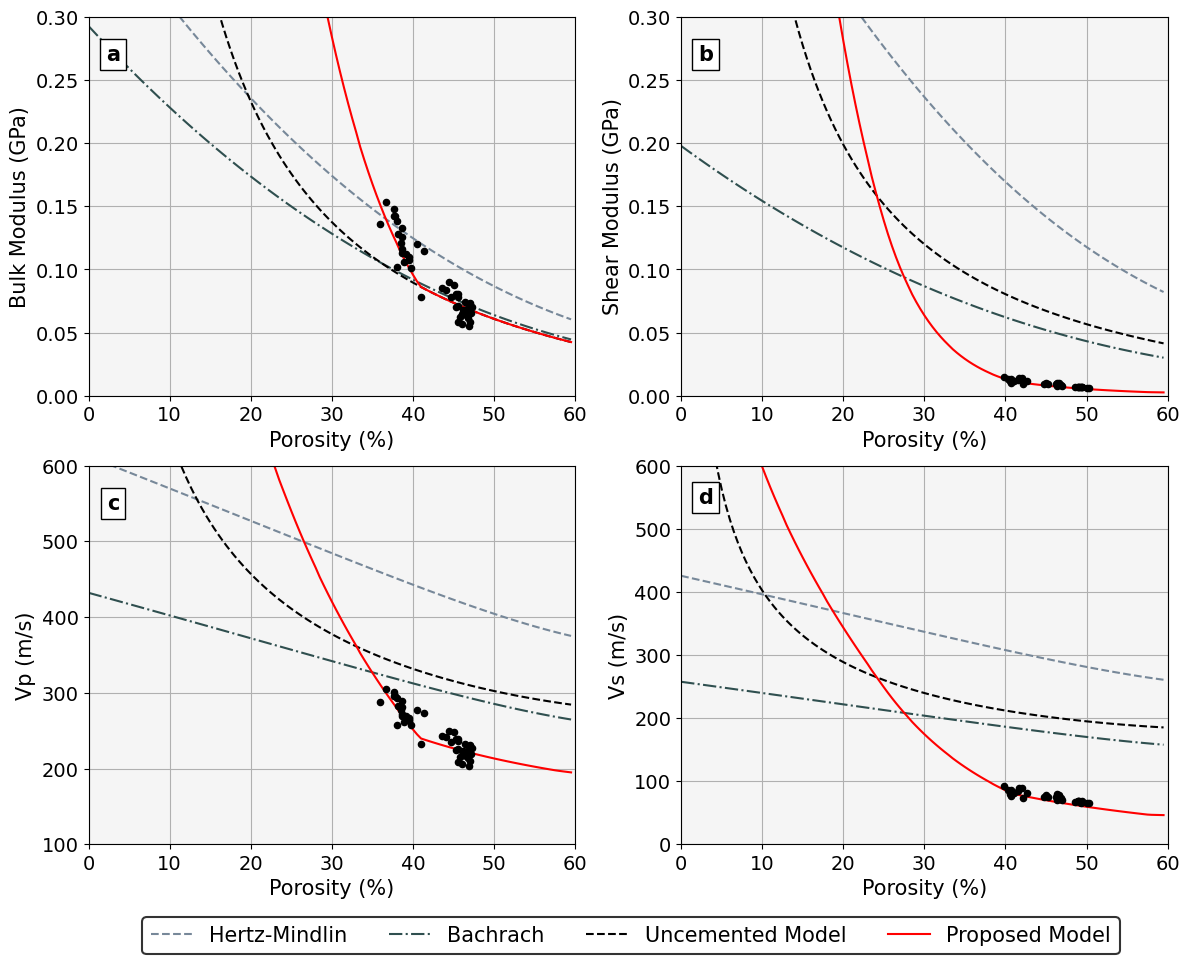

In [18]:
"""
Plot the 0.005 MPa measurements against various
Rock Physics Models
"""


## Model Parameters
pressure = pressures[0]  #GPa for calculations
max_poisson = max_poisson_list[0]

## Calculate RP models
por_range = np.arange(0,critical_porosity, 0.005)

vp_amos, vs_amos, k_amos, mu_amos = [], [], [], []
vp_bach, vs_bach, k_bach, mu_bach = [], [], [], []
vp_hm, vs_hm, k_hm, mu_hm = [], [], [], []
vp_uncem, vs_uncem, k_uncem, mu_uncem = [], [], [], []


for por in por_range:
    C_murphy = rp.models.modified_murphy(por)
    # C_murphy = rp.models.upper_murphy(por)
    C = 3
    dens = eff_min_density*(1-por)

    ## NOTE: pay attention if you need to use current or critical porosity!
    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = contact_ratios[0], slip_percent = slip_percent)
    kbach, ubach = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, por, C_murphy,
                                     pressure, c_ratio = .4, slip_percent = 0.9)
    khm, uhm = rp.models.hertz_mindlin(effective_mineral_k, effective_mineral_u, por, C_murphy,
                                     pressure, f=1)
    # kdigby, udigby = rp.models.digby(effective_mineral_k, effective_mineral_u, por, C_murphy, 
    #                       pressure, bond_ratio=0.01)
    # kwalton, uwalton = rp.models.walton(effective_mineral_k, effective_mineral_u, por, C_murphy, 
    #                        pressure, mode="smooth")
    
    keff_uncem, ueff_uncem = rp.models.uncemented_model(por, critical_porosity, keff, ueff, 
                                              effective_mineral_k, effective_mineral_u)
    keff_amos, ueff_amos = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=max_poisson,
                                           trans_por=0.41)
    # keff_amos, ueff_amos = rp.amos_model(por, critical_porosity, keff, ueff, 
    #                                         effective_mineral_k, effective_mineral_u,
    #                                            fit_por = fitting_por, max_poisson=max_poisson)

    vp_amos.append(rp.elastic.p_vel(keff_amos, ueff_amos, dens)*1000)
    vs_amos.append(rp.elastic.s_vel(ueff_amos, dens)*1000)
    k_amos.append(keff_amos)
    mu_amos.append(ueff_amos)

    vp_uncem.append(rp.elastic.p_vel(keff_uncem, ueff_uncem, dens)*1000)
    vs_uncem.append(rp.elastic.s_vel(ueff_uncem, dens)*1000)
    k_uncem.append(keff_uncem)
    mu_uncem.append(ueff_uncem)

    vp_bach.append(rp.elastic.p_vel(kbach, ubach, dens)*1000)
    vs_bach.append(rp.elastic.s_vel(ubach, dens)*1000)
    k_bach.append(kbach)
    mu_bach.append(ubach)

    vp_hm.append(rp.elastic.p_vel(khm, uhm, dens)*1000)
    vs_hm.append(rp.elastic.s_vel(uhm, dens)*1000)
    k_hm.append(khm)
    mu_hm.append(uhm)



## CALCULATE MODULI FROM MEASUREMENTS
shear_moduli = []
for vs, dens in zip(data_s[:,0], data_s[:,1]):
    shear_moduli.append(rp.elastic.shear_mod(vs, dens)/1000000)
vs_fit = np.poly1d(np.polyfit(data_s[:,2], data_s[:,0], deg=1))  #linear fit to VS/por
bulk_moduli = []
for vp, dens, por in zip(data_p[:,0], data_p[:,1], data_p[:,2]):
    vs = vs_fit(por)
    bulk_moduli.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
dot_size = 20
line_colors = ["lightslategray", "darkslategray", "black", "red"]
line_styles = ["--", "-.", "--", "-"]

ax[0,0].plot(por_range*100, k_hm, color=line_colors[0], ls=line_styles[0])
ax[0,0].plot(por_range*100, k_bach, color=line_colors[1], ls=line_styles[1])
ax[0,0].plot(por_range*100, k_uncem, color=line_colors[2], ls=line_styles[2])
ax[0,0].plot(por_range*100, k_amos, color=line_colors[3], ls=line_styles[3])
ax[0,0].scatter(data_p[:,2]*100, bulk_moduli, s=dot_size, color="black", zorder=100)
ax[0,0].set(xlim=(0., round(critical_porosity,2)*100),
          ylim=(0,0.3),
         # xlabel="Porosity (%)",
         # ylabel="K (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].set_xlabel("Porosity (%)", fontsize=15)
ax[0,0].set_ylabel("Bulk Modulus (GPa)", fontsize=15)
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].grid("both")
ax[0,0].text(3, 0.27, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


ax[0,1].plot(por_range*100, mu_hm, color=line_colors[0], ls=line_styles[0])
ax[0,1].plot(por_range*100, mu_bach, color=line_colors[1], ls=line_styles[1])
ax[0,1].plot(por_range*100, mu_uncem, color=line_colors[2], ls=line_styles[2])
ax[0,1].plot(por_range*100, mu_amos, color=line_colors[3], ls=line_styles[3])
ax[0,1].scatter(data_s[:,2]*100, shear_moduli, s=dot_size, color="black", zorder=100)
ax[0,1].set(xlim=(0., round(critical_porosity,2)*100),
          ylim=(0,0.3),
         # xlabel="Porosity (%)",
         # ylabel="Mu (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].set_xlabel("Porosity (%)", fontsize=15)
ax[0,1].set_ylabel("Shear Modulus (GPa)", fontsize=15)
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].grid("both")
ax[0,1].text(3, 0.27, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


ax[1,0].plot(por_range*100, vp_hm, color=line_colors[0], ls=line_styles[0])
ax[1,0].plot(por_range*100, vp_bach, color=line_colors[1], ls=line_styles[1])
ax[1,0].plot(por_range*100, vp_uncem, color=line_colors[2], ls=line_styles[2])
ax[1,0].plot(por_range*100, vp_amos, color=line_colors[3], ls=line_styles[3])
ax[1,0].scatter(data_p[:,2]*100, data_p[:,0], s=dot_size, color="black", zorder=100)
ax[1,0].set(xlim=(0., round(critical_porosity,2)*100),
         ylim=(100,600),
         # xlabel="Porosity (%)",
         # ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].set_xlabel("Porosity (%)", fontsize=15)
ax[1,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].grid("both")
ax[1,0].text(3, 550, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


ax[1,1].plot(por_range*100, vs_hm, color=line_colors[0], ls=line_styles[0])
ax[1,1].plot(por_range*100, vs_bach, color=line_colors[1], ls=line_styles[1])
ax[1,1].plot(por_range*100, vs_uncem, color=line_colors[2], ls=line_styles[2])
ax[1,1].plot(por_range*100, vs_amos, color=line_colors[3], ls=line_styles[3])
ax[1,1].scatter(data_s[:,2]*100, data_s[:,0], s=dot_size, color="black", zorder=100)
ax[1,1].set(xlim=(0., round(critical_porosity,2)*100),
         ylim=(0,600),
         # xlabel="Porosity (%)",
         # ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].set_xlabel("Porosity (%)", fontsize=15)
ax[1,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].grid("both")
ax[1,1].text(3, 550, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


## Setting legend manually, so make sure models are plotted in this order!
label_list = ["Hertz-Mindlin", "Bachrach", "Uncemented Model", "Proposed Model"]
legend = fig.legend(labels=label_list, bbox_to_anchor=(0.03, 0.03, 1., 1), ncols=4, 
           loc='lower center', fontsize=15)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig6_model_comp.jpg", dpi=1000, bbox_inches = "tight")
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig6_model_comp.pdf", dpi=600, bbox_inches="tight")

## Pressure modeling

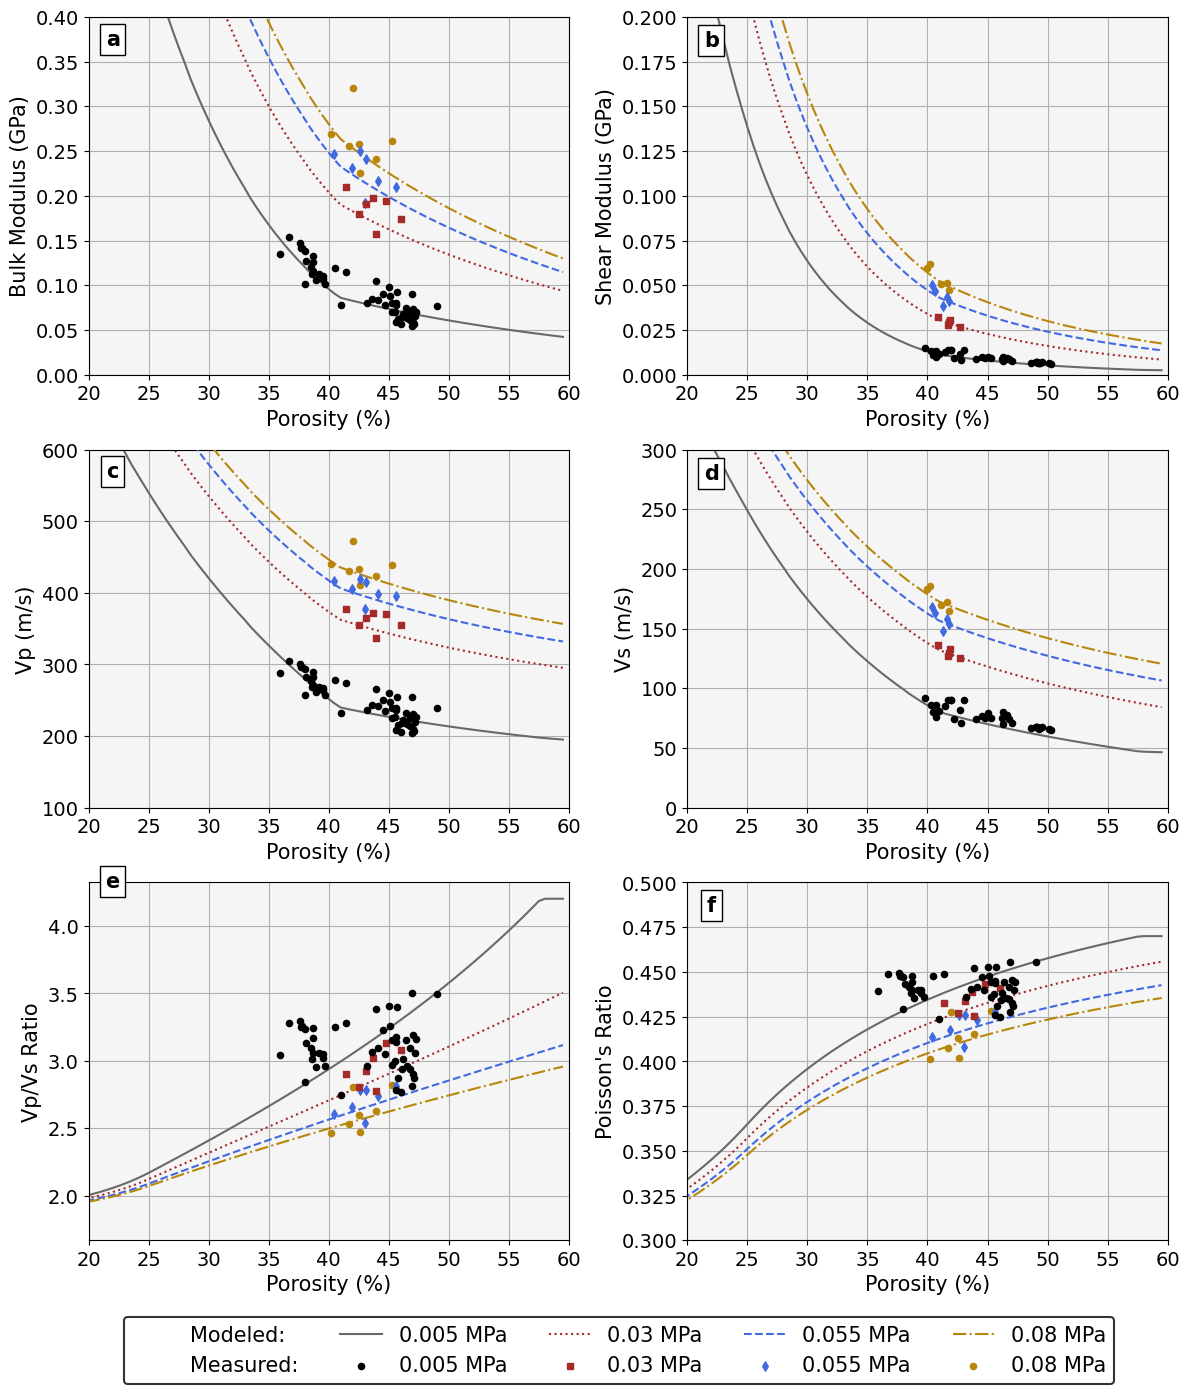

In [20]:
"""
Load picked velocity for the 4 pressure steps and plot against
the Rock Physics Model.

The "fitting PR" was calculated from average velocity values
at each pressure step, and then used to calculate the modeled
effective shear modulus for each pressure.

Note that parameters for the modified HM do not have to be altered
for each pressure, giving confidence that the model is robust within 
the sampled pressure range.
"""


## Model Parameters
por_range = np.arange(0,critical_porosity, 0.005)

## Calculate RP models
press_bulk_mods = []
press_shear_mods = []
press_bulk_mods_amos = []
press_shear_mods_amos = []
vp_amos = []
vs_amos = []

for por in por_range:
    # C = rp.models.upper_murphy(por)
    # C = rp.models.lower_murphy_bounded(por)
    # C = rp.models.modified_murphy(por)
    C = 3
    dens = eff_min_density*(1-por)

    tmp_vp_amos = []
    tmp_vs_amos = []
    tmp_k_amos = []
    tmp_mu_amos = []
    for pressure, max_poisson, contact_ratio in zip(pressures, max_poisson_list, contact_ratios):
        keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
        keff_amos, ueff_amos = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=max_poisson,
                                           trans_por=0.41)
        
        
        tmp_vp_amos.append(rp.elastic.p_vel(keff_amos, ueff_amos, dens)*1000)
        tmp_vs_amos.append(rp.elastic.s_vel(ueff_amos, dens)*1000)
        tmp_k_amos.append(keff_amos)
        tmp_mu_amos.append(ueff_amos)
    vp_amos.append(tmp_vp_amos)
    vs_amos.append(tmp_vs_amos)
    press_bulk_mods_amos.append(tmp_k_amos)
    press_shear_mods_amos.append(tmp_mu_amos)

vp_amos = np.array(vp_amos)
vs_amos = np.array(vs_amos)
press_bulk_mods = np.array(press_bulk_mods)
press_shear_mods = np.array(press_shear_mods)
press_bulk_mods_amos = np.array(press_bulk_mods_amos)
press_shear_mods_amos = np.array(press_shear_mods_amos)


## CALCULATE MODULI FROM MEASUREMENTS
shear_moduli_p00 = []
for vs, dens in zip(data_s[:,0], data_s[:,1]):
    shear_moduli_p00.append(rp.elastic.shear_mod(vs, dens)/1000000)
vs_fit = np.poly1d(np.polyfit(data_s[:,2], data_s[:,0], deg=1))  #linear fit to VS/por
bulk_moduli_p00, bulk_moduli_p0 = [], []
vpvs_p00, vpvs_p0 = [], []
pr_p00, pr_p0 = [], []
for vp, dens, por in zip(data_p[:,0], data_p[:,1], data_p[:,2]):
    vs = vs_fit(por)
    bulk_moduli_p00.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)
    vpvs_p00.append(vp/vs)
    pr_p00.append(rp.elastic.poisson_vel(vp, vs))
for vp, dens, por in zip(pres_step_0_p[:,0], pres_step_0_p[:,1], pres_step_0_p[:,2]):
    vs = vs_fit(por)
    bulk_moduli_p0.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)
    vpvs_p0.append(vp/vs)
    pr_p0.append(rp.elastic.poisson_vel(vp, vs))

shear_moduli_p0, shear_moduli_p1, shear_moduli_p2, shear_moduli_p3 = [], [], [], []
for vs, dens in zip(pres_step_0_s[:,0], pres_step_0_s[:,1]):
    shear_moduli_p0.append(rp.elastic.shear_mod(vs, dens)/1000000)
for vs, dens in zip(pres_step_1_s[:,0], pres_step_1_s[:,1]):
    shear_moduli_p1.append(rp.elastic.shear_mod(vs, dens)/1000000)
for vs, dens in zip(pres_step_2_s[:,0], pres_step_2_s[:,1]):
    shear_moduli_p2.append(rp.elastic.shear_mod(vs, dens)/1000000)
for vs, dens in zip(pres_step_3_s[:,0], pres_step_3_s[:,1]):
    shear_moduli_p3.append(rp.elastic.shear_mod(vs, dens)/1000000)

# use modeled Vs to calculate Bulk Mod, VpVs, and PR
bulk_moduli_p1, bulk_moduli_p2, bulk_moduli_p3 = [], [], []
vpvs_p1, vpvs_p2, vpvs_p3 = [], [], []
pr_p1, pr_p2, pr_p3 = [], [], []
for vp, dens, por in zip(pres_step_1_p[:,0], pres_step_1_p[:,1], pres_step_1_p[:,2]):
    tmp_idx = (np.abs(por_range-por)).argmin()
    vs = vs_amos[tmp_idx, 1]
    bulk_moduli_p1.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)
    vpvs_p1.append(vp/vs)
    pr_p1.append(rp.elastic.poisson_vel(vp, vs))
for vp, dens, por in zip(pres_step_2_p[:,0], pres_step_2_p[:,1], pres_step_2_p[:,2]):
    tmp_idx = (np.abs(por_range-por)).argmin()
    vs = vs_amos[tmp_idx, 2]
    bulk_moduli_p2.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)
    vpvs_p2.append(vp/vs)
    pr_p2.append(rp.elastic.poisson_vel(vp, vs))
for vp, dens, por in zip(pres_step_3_p[:,0], pres_step_3_p[:,1], pres_step_3_p[:,2]):
    tmp_idx = (np.abs(por_range-por)).argmin()
    vs = vs_amos[tmp_idx, 3]
    bulk_moduli_p3.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)
    vpvs_p3.append(vp/vs)
    pr_p3.append(rp.elastic.poisson_vel(vp, vs))
    

##----------------------------------
## PLOTS

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
dot_size = 20

## Moduli plots ~~~~~~~~~~~~~~~~~~~~~~~~
ax[0,0].plot(por_range*100, press_bulk_mods_amos[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0])
ax[0,0].scatter(data_p[:,2]*100, bulk_moduli_p00, s=dot_size, color="black", zorder=100,
               label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,0].scatter(pres_step_0_p[:,2]*100, bulk_moduli_p0, s=dot_size, color="black", zorder=101)
ax[0,0].plot(por_range*100, press_bulk_mods_amos[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1], ls=":")
ax[0,0].scatter(pres_step_1_p[:,2]*100, bulk_moduli_p1, s=dot_size, color=pres_colors[1],
              marker="s", zorder=99, label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,0].plot(por_range*100, press_bulk_mods_amos[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--")
ax[0,0].scatter(pres_step_2_p[:,2]*100, bulk_moduli_p2, s=dot_size+3, color=pres_colors[2],
               marker="d", zorder=98, label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,0].plot(por_range*100, press_bulk_mods_amos[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.")
ax[0,0].scatter(pres_step_3_p[:,2]*100, bulk_moduli_p3, s=dot_size, color=pres_colors[3], zorder=97,
               label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,0].set(xlim=(20, round(critical_porosity,2)*100),
          ylim=(0,0.4),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].set_xlabel("Porosity (%)", fontsize=15)
ax[0,0].set_ylabel("Bulk Modulus (GPa)", fontsize=15)
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].grid("both")
ax[0,0].text(22, 0.375, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[0,1].plot(por_range*100, press_shear_mods_amos[:,0], color=pres_colors[0])
ax[0,1].plot(por_range*100, press_shear_mods_amos[:,1], color=pres_colors[1], ls=":")
ax[0,1].plot(por_range*100, press_shear_mods_amos[:,2], color=pres_colors[2], ls="--")
ax[0,1].plot(por_range*100, press_shear_mods_amos[:,3], color=pres_colors[3], ls="-.")
ax[0,1].scatter(data_s[:,2]*100, shear_moduli_p00, s=dot_size, color="black", zorder=100)
ax[0,1].scatter(pres_step_0_s[:,2]*100, shear_moduli_p0, s=dot_size, color="black", zorder=101)
ax[0,1].scatter(pres_step_1_s[:,2]*100, shear_moduli_p1, s=dot_size, color=pres_colors[1], 
              marker="s", zorder=99)
ax[0,1].scatter(pres_step_2_s[:,2]*100, shear_moduli_p2, s=dot_size+3, color=pres_colors[2], 
               marker="d", zorder=98)
ax[0,1].scatter(pres_step_3_s[:,2]*100, shear_moduli_p3, s=dot_size, color=pres_colors[3], zorder=97)
ax[0,1].set(xlim=(20, round(critical_porosity,2)*100),
          ylim=(0,0.2),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].set_xlabel("Porosity (%)", fontsize=15)
ax[0,1].set_ylabel("Shear Modulus (GPa)", fontsize=15)
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].grid("both")
ax[0,1].text(22, 0.187, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

## Velocity Plots ~~~~~~~~~~~~~~~~~~~~~~~~
ax[1,0].plot(por_range*100, vp_amos[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0], zorder=1)
ax[1,0].plot(por_range*100, vp_amos[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1], ls=":", zorder=2)
ax[1,0].plot(por_range*100, vp_amos[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--", zorder=3)
ax[1,0].plot(por_range*100, vp_amos[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.", zorder=4)
ax[1,0].scatter(pres_step_0_p[:,2]*100, pres_step_0_p[:,0], s=dot_size, color="black", zorder=100)
ax[1,0].scatter(pres_step_1_p[:,2]*100, pres_step_1_p[:,0], s=dot_size, color=pres_colors[1],
              marker="s", zorder=99)
ax[1,0].scatter(pres_step_2_p[:,2]*100, pres_step_2_p[:,0], s=dot_size+3, color=pres_colors[2],
               marker="d", zorder=98)
ax[1,0].scatter(pres_step_3_p[:,2]*100, pres_step_3_p[:,0], s=dot_size, color=pres_colors[3], zorder=97)
ax[1,0].scatter(data_p[:,2]*100, data_p[:,0], s=dot_size, color="black", zorder=50)
ax[1,0].set(xlim=(20, round(critical_porosity,2)*100),
         ylim=(100,600),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].set_xlabel("Porosity (%)", fontsize=15)
ax[1,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].grid("both")
ax[1,0].text(22, 570, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[1,1].plot(por_range*100, vs_amos[:,0], label=str(round(pressures[0]*1000,3))+" MPa", color=pres_colors[0])
ax[1,1].plot(por_range*100, vs_amos[:,1], label=str(round(pressures[1]*1000,3))+" MPa",
           color=pres_colors[1], ls=":")
ax[1,1].plot(por_range*100, vs_amos[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--")
ax[1,1].plot(por_range*100, vs_amos[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.")
ax[1,1].scatter(pres_step_0_s[:,2]*100, pres_step_0_s[:,0], s=dot_size, color="black", zorder=100)
ax[1,1].scatter(pres_step_1_s[:,2]*100, pres_step_1_s[:,0], s=dot_size, color=pres_colors[1], 
              marker="s", zorder=99)
ax[1,1].scatter(pres_step_2_s[:,2]*100, pres_step_2_s[:,0], s=dot_size+3, color=pres_colors[2], 
               marker="d", zorder=98)
ax[1,1].scatter(pres_step_3_s[:,2]*100, pres_step_3_s[:,0], s=dot_size, color=pres_colors[3], zorder=97)
ax[1,1].scatter(data_s[:,2]*100, data_s[:,0], s=dot_size, color="black", zorder=50)
ax[1,1].set(xlim=(20, round(critical_porosity,2)*100),
         ylim=(0,300),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].set_xlabel("Porosity (%)", fontsize=15)
ax[1,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].grid("both")
ax[1,1].text(22, 280, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


## PR and VpVs plots ~~~~~~~~~~~~~~~~~~~~~~~~
ax[2,0].plot(por_range*100, vp_amos[:,0]/vs_amos[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0])
ax[2,0].plot(por_range*100, vp_amos[:,1]/vs_amos[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1], ls=":")
ax[2,0].plot(por_range*100, vp_amos[:,2]/vs_amos[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--")
ax[2,0].plot(por_range*100, vp_amos[:,3]/vs_amos[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.")
ax[2,0].scatter(data_p[:,2]*100, vpvs_p00, s=dot_size, color="black", zorder=100)
ax[2,0].scatter(pres_step_0_p[:,2]*100, vpvs_p0, s=dot_size, color="black", zorder=101)
ax[2,0].scatter(pres_step_1_p[:,2]*100, vpvs_p1, s=dot_size, color=pres_colors[1],
              marker="s", zorder=99)
ax[2,0].scatter(pres_step_2_p[:,2]*100, vpvs_p2, s=dot_size+3, color=pres_colors[2],
               marker="d", zorder=98)
ax[2,0].scatter(pres_step_3_p[:,2]*100, vpvs_p3, s=dot_size, color=pres_colors[3], zorder=97)
ax[2,0].set(xlim=(20, round(critical_porosity,2)*100),
         axisbelow=True,
         facecolor="whitesmoke")
ax[2,0].set_xlabel("Porosity (%)", fontsize=15)
ax[2,0].set_ylabel("Vp/Vs Ratio", fontsize=15)
ax[2,0].tick_params(axis='both', labelsize=14)
ax[2,0].grid("both")
ax[2,0].text(22, 4.33, "e", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[2,1].plot(por_range*100, rp.elastic.poisson_vel(vp_amos[:,0],vs_amos[:,0]), 
             label=str(round(pressures[0]*1000,3))+" MPa", color=pres_colors[0])
ax[2,1].plot(por_range*100, rp.elastic.poisson_vel(vp_amos[:,1],vs_amos[:,1]), 
             label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1], ls=":")
ax[2,1].plot(por_range*100, rp.elastic.poisson_vel(vp_amos[:,2],vs_amos[:,2]), 
             label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2], ls="--")
ax[2,1].plot(por_range*100, rp.elastic.poisson_vel(vp_amos[:,3],vs_amos[:,3]), 
             label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3], ls="-.")
ax[2,1].scatter(data_p[:,2]*100, pr_p00, s=dot_size, color="black", zorder=100)
ax[2,1].scatter(pres_step_0_p[:,2]*100, pr_p0, s=dot_size, color="black", zorder=101)
ax[2,1].scatter(pres_step_1_p[:,2]*100, pr_p1, s=dot_size, color=pres_colors[1], 
              marker="s", zorder=99)
ax[2,1].scatter(pres_step_2_p[:,2]*100, pr_p2, s=dot_size+3, color=pres_colors[2], 
               marker="d", zorder=98)
ax[2,1].scatter(pres_step_3_p[:,2]*100, pr_p3, s=dot_size, color=pres_colors[3], zorder=97)
ax[2,1].set(xlim=(20, round(critical_porosity,2)*100),
            ylim=(0.3, 0.5),
         axisbelow=True,
         facecolor="whitesmoke")
ax[2,1].set_xlabel("Porosity (%)", fontsize=15)
ax[2,1].set_ylabel("Poisson's Ratio", fontsize=15)
ax[2,1].tick_params(axis='both', labelsize=14)
ax[2,1].grid("both")
ax[2,1].text(22, 0.487, "f", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

h, l = ax[0,0].get_legend_handles_labels()
ph = [ax[0,0].plot([], marker="", ls="")[0]] * 2
handles = ph + h

labels = ["Modeled:", "Measured:"] + l
legend = fig.legend(handles, labels, bbox_to_anchor=(0.02, 0.0, 1., 1), ncols=5, 
           loc='lower center', fontsize=15)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.subplots_adjust(bottom=0.11)

plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig7_pressure_plots.jpg", dpi=1000)
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig7_pressure_plots.pdf", dpi=600)

C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


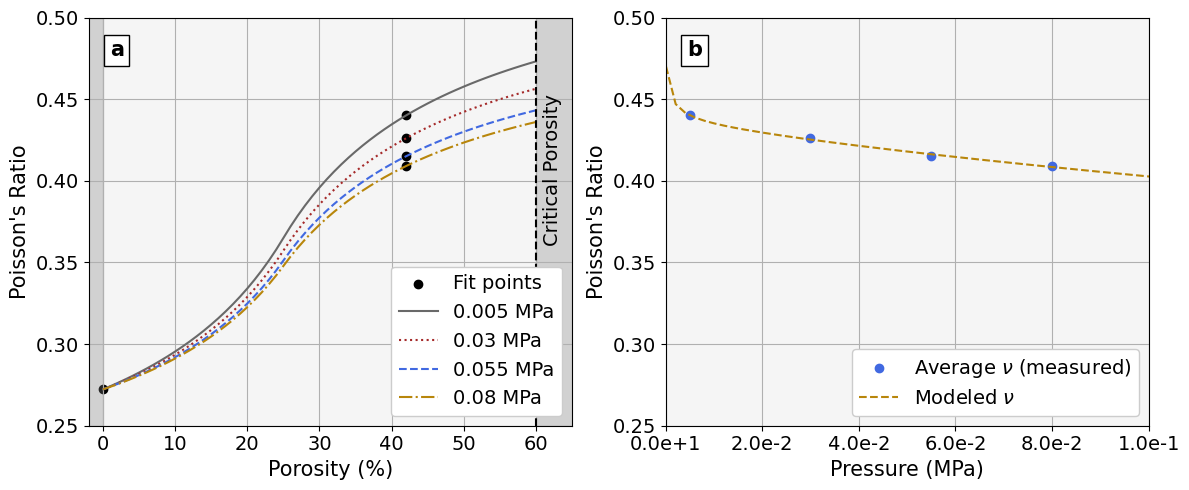

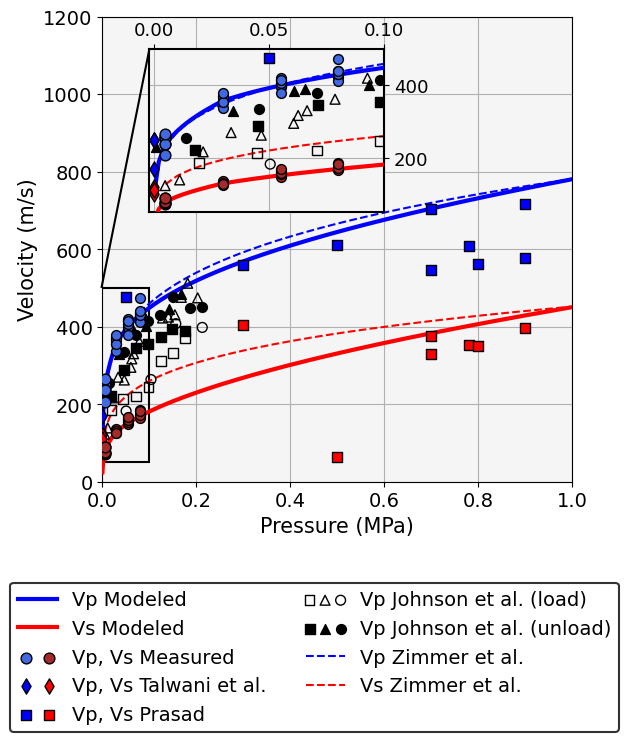

In [24]:
"""
It is observed that even including slip factor and grain
contact ratio (after Bachrach) the shear velocity is still
overpredicted. To compensate, this workflow uses the average
Vp and Vs at each pressure step to calculate a fitting Poisson's
ratio. A function is fit between these points and the mineral
Poisson's ratio versus porosity. The effective shear modulus
is then be estimated based on the calculated effective bulk
modulus and this PR fitting function for each pressure step.

Use a root function to fit between mineral PR and averaged
fitting PR under the notion that near critical porosity or the 
mineral point, PR will behave similar to those end member conditions.

This cell illustrates how the "fitting_por" and "max_poisson_list"
variables are determined for the model above.

Additionally, investigate the pressure-PR relationship established 
by fitting models above in order to calculate the 
"fitting PR" for a given pressure/depth.

Plot PR calculated from RPM over given pressure range
at a constant porosity.

Plot Vp and Vs against pressure. Add measured data points,
but note that they don't strictly correspond to this porosity
leading to a slight visual disconnect with the above pressure
plots (would be akin to projecting above points to 0.42 porosity)
"""

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CREATE THE PR vs POROSITY SIGMOID CURVES

## Average porosity for the Vp and Vs pressure measurements
# fit_avg_por = np.mean((np.mean(data_pressure_p[:,2]), np.mean(data_pressure_s[:,2])))
fit_avg_por = fitting_por  ## manual overwrite
# print(f"The average fitting porosity is {round(fit_avg_por,2)}")

## Average Poisson's Ratio at each pressure step
# p0_avg_pr = rp.elastic.poisson_vel(np.mean(pres_step_0_p[:,0]), np.mean(pres_step_0_s[:,0]))
# p1_avg_pr = rp.elastic.poisson_vel(np.mean(pres_step_1_p[:,0]), np.mean(pres_step_1_s[:,0]))
# p2_avg_pr = rp.elastic.poisson_vel(np.mean(pres_step_2_p[:,0]), np.mean(pres_step_2_s[:,0]))
# p3_avg_pr = rp.elastic.poisson_vel(np.mean(pres_step_3_p[:,0]), np.mean(pres_step_3_s[:,0]))
# fit_poissons = [p0_avg_pr, p1_avg_pr, p2_avg_pr, p3_avg_pr]
fit_poissons = max_poisson_list


## Define the root function that will be used for fitting,
## holding two variables constant to control the degree
## and location of function slope
def fit_func_bounded(x, vert_stretch, vert_translate):
    horz_translate = 0.25
    curve_factor = 0.25
    return vert_stretch * ((x-horz_translate)/(curve_factor + np.abs(x-horz_translate))) + vert_translate


## For each pressure step, fit the PR-fitting function
fit_parms = []
initial_guess = [0.2, 0.3]
for pr in fit_poissons:
    fit_x = [0, fit_avg_por]
    fit_y = [poisson_grain, pr]
    fit_parm, _ = optimize.curve_fit(fit_func_bounded, fit_x, fit_y, p0=initial_guess)
    fit_parms.append(fit_parm)

## PR points for plotting
pr_x = [0, fit_avg_por, fit_avg_por, fit_avg_por, fit_avg_por]
pr_y = [poisson_grain, fit_poissons[0], fit_poissons[1], fit_poissons[2], fit_poissons[3]]




##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CREATE THE PR vs PRESSURE ROOT CURVE

pres_range = np.linspace(0.0000001,0.0010, 500)  ## in GPa for modeling

## Perform polynomial fit to average PR values from measurements
## Add near-intercept point to control fit
_fitpres = np.insert(pressures, 0, 0.0000001)
_fitpr = np.insert(max_poisson_list, 0, 0.49) 
pr_fit = np.poly1d(np.polyfit(_fitpres**(1/10), _fitpr, deg=3))
# est_pr = []
# for p in pres_range:
#     est_pr.append(pr_fit(p**(1/10)))

    

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CALCULATE VELOCITY BASED ON OUR RPM

por_calc = fitting_por  # based on avg. por from pressure measurements
dens = eff_min_density*(1-por_calc)
C = 3
est_pr_hm = []
est_pr_amos = []
vp_amos = []
vs_amos = []
power_1_6 = []
power_1_3 = []
power_1_4 = []
power_1_5 = []
power_1_4_s = []
for p in pres_range:
    ## Estimate a contact ratio based on pressure
    if p <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - p)).argmin()
        tmp_cr_range = np.linspace(0.2, contact_ratios[0], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < p <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - p)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    
    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         p, c_ratio = contact_ratio, slip_percent = slip_percent)
    k_amos, u_amos = rp.models.amos_isoframe_model(por_calc, critical_porosity, keff, ueff, 
                                        effective_mineral_k, effective_mineral_u, 
                                     fit_por = por_calc, max_poisson=pr_fit(p**(1/10)),
                                           trans_por=0.41) 
    hm_pr_amos = rp.elastic.poisson_mod(k_amos, u_amos)
    est_pr_amos.append(hm_pr_amos)

    vp_amos.append(rp.elastic.p_vel(k_amos, u_amos, dens)*1000)
    vs_amos.append(rp.elastic.s_vel(u_amos, dens)*1000)


    ## Add a 1/6 power curve
    power_1_6.append(520*((p)/0.0002)**(1/6.))
    power_1_3.append(520*((p)/0.0002)**(1/3.))
    power_1_4.append(520*((p)/0.0002)**(1/4.))
    power_1_5.append(520*((p)/0.0002)**(1/5.))
    power_1_4_s.append(230*((p)/0.0002)**(1/3.4))


## Plot the data from Johnson's measurements on Apollo samples
# plot_johnson = True   #whether to add to plot
d1, d2, d3, d4 = 1.29, 1.39, 1.53, 1.87 #reported sample densities
d1_load = johnson_data[(johnson_data[:,0]==1)&(johnson_data[:,1]==d1)]
d1_unload = johnson_data[(johnson_data[:,0]==1)&(johnson_data[:,1]==d4)]
d2_load = johnson_data[(johnson_data[:,0]==2)&(johnson_data[:,1]==d2)]
d2_unload = johnson_data[(johnson_data[:,0]==2)&(johnson_data[:,1]==d4)]
d3_load = johnson_data[(johnson_data[:,0]==3)&(johnson_data[:,1]==d3)]
d3_unload = johnson_data[(johnson_data[:,0]==3)&(johnson_data[:,1]==d4)]


## Create curves from Zimmer et al. 2007 
def zimmer_vel(S, n_2, k, pressure):
    vel = 1**k * S * (pressure/0.1)**n_2
    return vel

# Use the weighted mean parameter values
p_zim_vals = {"S": 460., "n_2": 0.23, "k": 0.03}
s_zim_vals = {"S": 260., "n_2": 0.24, "k": 0.01}

zim_pres_range = np.arange(0.005, 1, 0.005)  ## in MPa for plotting

zim_vp, zim_vs = [], []

for p in zim_pres_range:
    zim_vp.append(zimmer_vel(**p_zim_vals, pressure=p))
    zim_vs.append(zimmer_vel(**s_zim_vals, pressure=p))


##---
def betancourt_vel(n1, exp, pressure):
    vel = n1*(pressure/0.001)**exp
    return vel

p_betancourt_vals = {"n1":109.47, "exp":0.314}
s_betancourt_vals = {"n1":72.73, "exp":0.306}

betancourt_pres_range = np.arange(0.001, 1, 0.005)  ## in MPa for plotting

betancourt_vp, betancourt_vs = [], []

for p in betancourt_pres_range:
    betancourt_vp.append(betancourt_vel(**p_betancourt_vals, pressure=p))
    betancourt_vs.append(betancourt_vel(**s_betancourt_vals, pressure=p))


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## PLOTS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
x = np.arange(0, critical_porosity+0.01, 0.01)

pres_labels = [str(round(pressures[0]*1000,3))+" MPa", str(round(pressures[1]*1000,3))+" MPa",
         str(round(pressures[2]*1000,3))+" MPa", str(round(pressures[3]*1000,3))+" MPa"]
ax[0].scatter(pr_x, pr_y, c="black", label="Fit points")
# for i, fit_parm in enumerate(fit_parms):
#     ax[0].plot(x, fit_func_bounded(x, *fit_parm), color=pres_colors[i], label=pres_labels[i])
ax[0].plot(x, fit_func_bounded(x, *fit_parms[0]), color=pres_colors[0], label=pres_labels[0])
ax[0].plot(x, fit_func_bounded(x, *fit_parms[1]), color=pres_colors[1], label=pres_labels[1], ls=":")
ax[0].plot(x, fit_func_bounded(x, *fit_parms[2]), color=pres_colors[2], label=pres_labels[2], ls="--")
ax[0].plot(x, fit_func_bounded(x, *fit_parms[3]), color=pres_colors[3], label=pres_labels[3], ls="-.")
ax[0].axvspan(-1, 0, color="gray", alpha=0.3)
ax[0].axvspan(critical_porosity, 1, color="gray", alpha=0.3)
ax[0].axvline(critical_porosity, linestyle="--", color="black")
ax[0].text(critical_porosity+0.01,0.36, "Critical Porosity", va="bottom", ha="left", rotation=90, fontsize=14)
ax[0].set(# title="Root function fit to Poisson's Ratio",
         xlim=(-0.02, 0.65),
         ylim=(0.25, 0.5),
         facecolor="whitesmoke")
ax[0].legend(loc="lower right", fontsize=14, framealpha=1)
ax[0].set_xlabel("Porosity (%)", fontsize=15)
ax[0].set_ylabel("Poisson's Ratio", fontsize=15)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].grid("both")
ax[0].text(0.019, 0.48, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
tick_pos = ax[0].get_xticks()
ax[0].set_xticks(tick_pos[1:-1], [int(i*100) for i in tick_pos[1:-1]])


ax[1].scatter([i*1000 for i in pressures], max_poisson_list, 
            c='royalblue', label=("Average {} (measured)".format(r'$\nu$')))
ax[1].plot(pres_range*1000, est_pr_amos, color="darkgoldenrod", ls="--", label=("Modeled "+ r"$\nu$"))
ax[1].legend(fontsize=14, framealpha=1, loc="lower right")
ax[1].xaxis.set_major_formatter(major_formatter2)
ax[1].set(ylim = (0.25, 0.5),
              # xlim=(0, pres_range[-1]*1000),
              xlim=(0, 1.e-1),
              axisbelow=True,
              facecolor="whitesmoke")  
ax[1].set_xlabel("Pressure (MPa)", fontsize=15)
ax[1].set_ylabel("Poisson's Ratio", fontsize=15)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].grid("both")
ax[1].text(0.006, 0.48, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/figB1_pr_pres.jpg", dpi=1000)



#-----------
fig, ax = plt.subplots(figsize=(6,6.5))

dot_size = 50
modp, = ax.plot(pres_range*1000, vp_amos, color="blue", lw=3, zorder=5)
# ax.plot(pres_range*1000, np.array(vp_amos)*.75, color="orange")
mods, = ax.plot(pres_range*1000, vs_amos, color="red", lw=3, zorder=5)
# ax.plot(pres_range*1000, power_1_6, "--", color="brown", label="1/6 Power")
# ax.plot(pres_range*1000, power_1_3, "--", color="cyan", label="1/3 Power")
# ax.plot(pres_range*1000, power_1_4, "--", color="orange", label="1/4 Power")
# ax.plot(pres_range*1000, power_1_5, "--", color="lime", label="1/5 Power")
# ax.plot(pres_range*1000, power_1_4_s, "--", color="lime", label="1/4 Power")
measp = ax.scatter(pres_step_0_p[:,3], pres_step_0_p[:,0], s=dot_size+10, facecolors="royalblue", 
                   edgecolors="black", zorder=120)
ax.scatter(pres_step_1_p[:,3], pres_step_1_p[:,0], s=dot_size, facecolors="royalblue", 
           edgecolors="black", zorder=120)
ax.scatter(pres_step_2_p[:,3], pres_step_2_p[:,0], s=dot_size, facecolors="royalblue", 
           edgecolors="black", zorder=120)
ax.scatter(pres_step_3_p[:,3], pres_step_3_p[:,0], s=dot_size, facecolors="royalblue", 
           edgecolors="black", zorder=120)
meass = ax.scatter(pres_step_0_s[:,3], pres_step_0_s[:,0], s=dot_size+10, facecolors="brown", 
                   edgecolors="black", zorder=120)
ax.scatter(pres_step_1_s[:,3], pres_step_1_s[:,0], s=dot_size, facecolors="brown", 
           edgecolors="black", zorder=120)
ax.scatter(pres_step_2_s[:,3], pres_step_2_s[:,0], s=dot_size, facecolors="brown", 
           edgecolors="black", zorder=120)
ax.scatter(pres_step_3_s[:,3], pres_step_3_s[:,0], s=dot_size, facecolors="brown", 
           edgecolors="black", zorder=120)

## add talwani data
talp = ax.scatter(talwani_pressure, talwani_vp, s=dot_size+10, edgecolors="black", 
                  facecolors="blue", marker="d", zorder=110)
tals = ax.scatter(talwani_pressure, talwani_vs, s=dot_size+10, edgecolors="black", 
                  facecolors="red", marker="d", zorder=110)

## add prasad data (note last 2 points have 0 Vs so omit)
prap = ax.scatter(prasad_pres, prasad_vp, s=dot_size, edgecolors="black", 
                  facecolors="blue", marker="s", zorder=110)
pras = ax.scatter(prasad_pres[:-2], prasad_vs[:-2], s=dot_size, edgecolors="black", 
                  facecolors="red", marker="s", zorder=110)

## add johnson data
jl1 = ax.scatter(d1_load[:,2], d1_load[:,-1], s=dot_size, color="black", marker="s", 
                 facecolors="none", zorder=100)
ju1 = ax.scatter(d1_unload[:,2], d1_unload[:,-1], s=dot_size, color="black", marker="s", 
                 facecolors="black", zorder=100)
jl2 = ax.scatter(d2_load[:,2], d2_load[:,-1], s=dot_size, color="black", marker="^", 
                 facecolors="none", zorder=100)
ju2 = ax.scatter(d2_unload[:,2], d2_unload[:,-1], s=dot_size, color="black", marker="^", 
                 facecolors="black", zorder=100)
jl3 = ax.scatter(d3_load[:,2], d3_load[:,-1], s=dot_size, color="black", marker="o", 
                 facecolors="none", zorder=100)
ju3 = ax.scatter(d3_unload[:,2], d3_unload[:,-1], s=dot_size, color="black", marker="o", 
                 facecolors="black", zorder=100)

## add zimmer velocity
zim_p, = ax.plot(zim_pres_range, zim_vp, color="blue", zorder=2, ls="--")
zim_s, = ax.plot(zim_pres_range, zim_vs, color="red", zorder=2, ls="--")

##---
# ax.plot(betancourt_pres_range, betancourt_vp, color="lime")
# ax.plot(betancourt_pres_range, betancourt_vs, color="yellow")


# ax.xaxis.set_major_formatter(major_formatter2)
ax.set(ylim = (0., 1200),
              # xlim=(0, pres_range[-1]*1000),
              xlim=(0, 1),
              axisbelow=True,
              facecolor="whitesmoke")
ax.set_xlabel("Pressure (MPa)", fontsize=15)
ax.set_ylabel("Velocity (m/s)", fontsize=15)
ax.tick_params(axis='both', labelsize=14)
ax.grid("both")



handles = [modp, mods, (measp, meass), (talp, tals), (prap, pras), (jl1, jl2, jl3), 
           (ju1, ju2, ju3), zim_p, zim_s]
labels = ["Vp Modeled", "Vs Modeled", "Vp, Vs Measured", "Vp, Vs Talwani et al.", "Vp, Vs Prasad",
          "Vp Johnson et al. (load)", "Vp Johnson et al. (unload)", "Vp Zimmer et al.", "Vs Zimmer et al."]
legend = fig.legend(handles, labels, bbox_to_anchor=(0.02, -0.15, 1., 1), ncols=2, 
           loc='lower center', fontsize=14, handler_map={tuple: HandlerTuple(ndivide=None)})

# handles = [modp, mods, measp, meass, (jl1, jl2, jl3), (ju1, ju2, ju3), talp, tals]
# labels = ["Vp Modeled", "Vs Modeled", "Vp Measured", "Vs Measured", "Vp Johnson et al. (load)", 
#           "Vp Johnson et al. (unload)", "Vp Talwani et al.", "Vs Talwani et al."]
# legend = fig.legend(handles, labels, bbox_to_anchor=(0.02, -0.15, 1., 1), ncols=2, 
#            loc='lower center', fontsize=14, handler_map={tuple: HandlerTuple(ndivide=None)})

## inset zoom
# inset_placement = [0.4, 0.77, 0.5, 0.4]
inset_placement = [0.1, 0.58, 0.5, 0.35]
inset_xlims = (-0.002, 1e-1)
inset_ylims = (50, 500)
axin = ax.inset_axes(inset_placement)
axin.plot(pres_range*1000, vp_amos, color="blue", lw=3, zorder=5)
axin.plot(pres_range*1000, vs_amos, color="red", lw=3, zorder=5)
axin.scatter(pres_step_0_p[:,3], pres_step_0_p[:,0], s=dot_size+10, facecolors="royalblue", 
                   edgecolors="black", zorder=120)
axin.scatter(pres_step_1_p[:,3], pres_step_1_p[:,0], s=dot_size, facecolors="royalblue", 
           edgecolors="black", zorder=120)
axin.scatter(pres_step_2_p[:,3], pres_step_2_p[:,0], s=dot_size, facecolors="royalblue", 
           edgecolors="black", zorder=120)
axin.scatter(pres_step_3_p[:,3], pres_step_3_p[:,0], s=dot_size, facecolors="royalblue", 
           edgecolors="black", zorder=120)
axin.scatter(pres_step_0_s[:,3], pres_step_0_s[:,0], s=dot_size+10, facecolors="brown", 
                   edgecolors="black", zorder=120)
axin.scatter(pres_step_1_s[:,3], pres_step_1_s[:,0], s=dot_size, facecolors="brown", 
           edgecolors="black", zorder=120)
axin.scatter(pres_step_2_s[:,3], pres_step_2_s[:,0], s=dot_size, facecolors="brown", 
           edgecolors="black", zorder=120)
axin.scatter(pres_step_3_s[:,3], pres_step_3_s[:,0], s=dot_size, facecolors="brown", 
           edgecolors="black", zorder=120)
axin.scatter(talwani_pressure, talwani_vp, s=dot_size+10, edgecolors="black", 
                  facecolors="blue", marker="d", zorder=110)
axin.scatter(talwani_pressure, talwani_vs, s=dot_size+10, edgecolors="black", 
                  facecolors="red", marker="d", zorder=110)
axin.scatter(prasad_pres, prasad_vp, s=dot_size, edgecolors="black", 
                  facecolors="blue", marker="s", zorder=110)
axin.scatter(prasad_pres[:-2], prasad_vs[:-2], s=dot_size, edgecolors="black", 
                  facecolors="red", marker="s", zorder=110)
axin.scatter(d1_load[:,2], d1_load[:,-1], s=dot_size, color="black", marker="s", 
                 facecolors="none", zorder=100)
axin.scatter(d1_unload[:,2], d1_unload[:,-1], s=dot_size, color="black", marker="s", 
                 facecolors="black", zorder=100)
axin.scatter(d2_load[:,2], d2_load[:,-1], s=dot_size, color="black", marker="^", 
                 facecolors="none", zorder=100)
axin.scatter(d2_unload[:,2], d2_unload[:,-1], s=dot_size, color="black", marker="^", 
                 facecolors="black", zorder=100)
axin.scatter(d3_load[:,2], d3_load[:,-1], s=dot_size, color="black", marker="o", 
                 facecolors="none", zorder=100)
axin.scatter(d3_unload[:,2], d3_unload[:,-1], s=dot_size, color="black", marker="o", 
                 facecolors="black", zorder=100)
axin.plot(zim_pres_range, zim_vp, color="blue", zorder=2, ls="--")
axin.plot(zim_pres_range, zim_vs, color="red", zorder=2, ls="--")
axin.set(xlim = (inset_xlims[0], inset_xlims[1]),
        ylim = (inset_ylims[0], inset_ylims[1]),
        facecolor = "whitesmoke")
axin.grid('both')
# axin.invert_yaxis()
axin.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
                axis='both', labelsize=13)
axin.yaxis.tick_right()
patch, pp1, pp2 = mark_inset(ax, axin, loc1=2, loc2=1, lw=1.5)
pp2.set_visible(False)
for axis in ['top','bottom','left','right']:
    axin.spines[axis].set_linewidth(1.5)

legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor("black")
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig8_pres_johnson.jpg", dpi=1000, bbox_inches = "tight")
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig8_pres_johnson.pdf", dpi=600, bbox_inches="tight")

## Define density/porosity profile for lunar regolith, model velocity profiles

C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


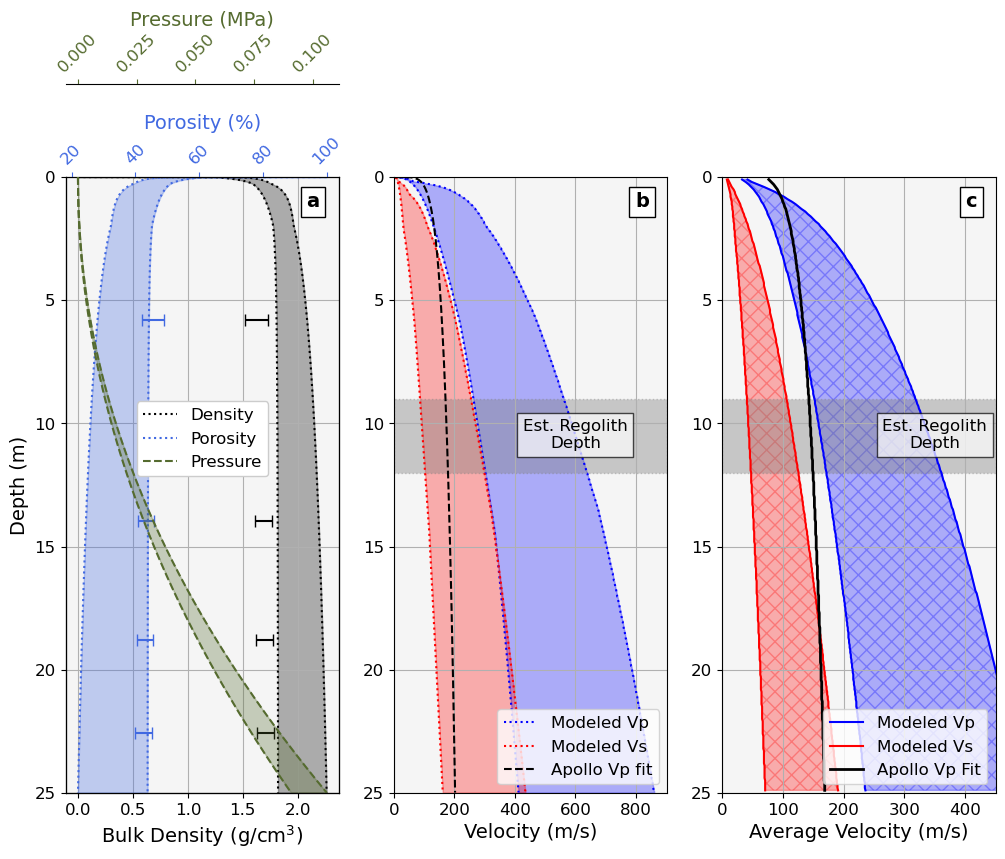

In [25]:
"""
Note discrepancy between lab measured porosity (density) and
that calculated from Lunar Sourcebook relationships. If we assume
the calculated in situ values are correct, then some form 
of additional porosity reduction technique (ultrasonic vibration?)
could help 
"""
##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES

## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Specific gravity of regolith
sg_low = 2.9
sg_high = 3.24

## Depth range, in m
max_depth = 25
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equations from Lunar Sourcebook, in g/cm3, page 494
## Assume 5% error for lows and highs calculations
dens_err = 0.05
densities_hyp = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))   #hyperbolic function
densities_pow = 1.39*(depths*100)**0.056
dens_stk = np.vstack((densities_hyp, densities_pow))
dens_low = np.amin(dens_stk, axis=0) * (1-dens_err)
dens_high = np.amax(dens_stk, axis=0) * (1+dens_err)

## Calculate porosity low and high
por_low = 1 - (dens_high / sg_low)
por_high = 1 - (dens_low / sg_high)


## Pressure, in MPa
integrated_density_low = integrate.cumulative_trapezoid(dens_low)
integrated_density_high = integrate.cumulative_trapezoid(dens_high)
ss_pressures_low = np.cumsum((grav_accel * integrated_density_low * depth_step) / 1e6)
ss_pressures_low = np.hstack((0, ss_pressures_low))
ss_pressures_high = np.cumsum((grav_accel * integrated_density_high * depth_step) / 1e6)
ss_pressures_high = np.hstack((0, ss_pressures_high))
ss_pressures_avg = np.mean((ss_pressures_low, ss_pressures_high), axis=0)

## Calculate velocity using model parameters established above and these
## porosity/pressure profiles
vp_amos_low = []
vs_amos_low = []
for por, pressure, dens in zip(por_high, ss_pressures_low, dens_low):
    if pressure==0:
        continue
    ## Change pressure to GPa
    pressure = pressure/1000

    C = 3

    ## Estimate a contact ratio based on pressure
    if pressure <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(0.25, contact_ratios[0], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < pressure <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    ## Using model parameters derived from primary sample chamber
    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
    keff_amos, ueff_amos = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=pr_fit(pressure**(1/10)),
                                           trans_por=0.41)
    vp_amos_low.append(rp.elastic.p_vel(keff_amos, ueff_amos, dens)*1000)
    vs_amos_low.append(rp.elastic.s_vel(ueff_amos, dens)*1000)

vp_amos_high = []
vs_amos_high = []
for por, pressure, dens in zip(por_low, ss_pressures_high, dens_high):
    if pressure==0:
        continue
    ## Change pressure to GPa
    pressure = pressure/1000

    C = 3

    ## Estimate a contact ratio based on pressure
    if pressure <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(0.25, contact_ratios[0], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < pressure <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    ## Using model parameters derived from primary sample chamber
    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
    keff_amos, ueff_amos = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=pr_fit(pressure**(1/10)),
                                           trans_por=0.41)
    vp_amos_high.append(rp.elastic.p_vel(keff_amos, ueff_amos, dens)*1000)
    vs_amos_high.append(rp.elastic.s_vel(ueff_amos, dens)*1000)

    
vp_amos_low = np.hstack((np.nan, np.array(vp_amos_low)))
vs_amos_low = np.hstack((np.nan, np.array(vs_amos_low)))
vp_amos_high = np.hstack((np.nan, np.array(vp_amos_high)))
vs_amos_high = np.hstack((np.nan, np.array(vs_amos_high)))

## Grab experimental density and porosity data for plotting
pres0 = pres_step_0_p[0,3]
pres1 = pres_step_1_p[0,3]
pres2 = pres_step_2_p[0,3]
pres3 = pres_step_3_p[0,3]
pres0_idx = (np.abs(ss_pressures_avg - pres0)).argmin()
pres1_idx = (np.abs(ss_pressures_avg - pres1)).argmin()
pres2_idx = (np.abs(ss_pressures_avg - pres2)).argmin()
pres3_idx = (np.abs(ss_pressures_avg - pres3)).argmin()
pres_depths = np.array([depths[pres0_idx], depths[pres1_idx], depths[pres2_idx], depths[pres3_idx]])

pres0_dens = np.mean(np.concatenate((pres_step_0_p[:,1], pres_step_0_s[:,1])))
pres1_dens = np.mean(np.concatenate((pres_step_1_p[:,1], pres_step_1_s[:,1])))
pres2_dens = np.mean(np.concatenate((pres_step_2_p[:,1], pres_step_2_s[:,1])))
pres3_dens = np.mean(np.concatenate((pres_step_3_p[:,1], pres_step_3_s[:,1])))
pres_densities = np.array([pres0_dens ,pres1_dens, pres2_dens, pres3_dens])

pres0_dens_min = np.amin(np.concatenate((pres_step_0_p[:,1], pres_step_0_s[:,1])))
pres1_dens_min = np.amin(np.concatenate((pres_step_1_p[:,1], pres_step_1_s[:,1])))
pres2_dens_min = np.amin(np.concatenate((pres_step_2_p[:,1], pres_step_2_s[:,1])))
pres3_dens_min = np.amin(np.concatenate((pres_step_3_p[:,1], pres_step_3_s[:,1])))
pres_densities_min = np.array([pres0_dens_min ,pres1_dens_min, pres2_dens_min, pres3_dens_min])
pres_densities_min = np.abs(pres_densities-pres_densities_min)

pres0_dens_max = np.amax(np.concatenate((pres_step_0_p[:,1], pres_step_0_s[:,1])))
pres1_dens_max = np.amax(np.concatenate((pres_step_1_p[:,1], pres_step_1_s[:,1])))
pres2_dens_max = np.amax(np.concatenate((pres_step_2_p[:,1], pres_step_2_s[:,1])))
pres3_dens_max = np.amax(np.concatenate((pres_step_3_p[:,1], pres_step_3_s[:,1])))
pres_densities_max = np.array([pres0_dens_max ,pres1_dens_max, pres2_dens_max, pres3_dens_max])
pres_densities_max = np.abs(pres_densities-pres_densities_max)

dens_minmax = [pres_densities_min, pres_densities_max]

pres0_por = np.mean(np.concatenate((pres_step_0_p[:,2], pres_step_0_s[:,2])))
pres1_por = np.mean(np.concatenate((pres_step_1_p[:,2], pres_step_1_s[:,2])))
pres2_por = np.mean(np.concatenate((pres_step_2_p[:,2], pres_step_2_s[:,2])))
pres3_por = np.mean(np.concatenate((pres_step_3_p[:,2], pres_step_3_s[:,2])))
pres_porosities = np.array([pres0_por, pres1_por, pres2_por, pres3_por])

pres0_por_min = np.amin(np.concatenate((pres_step_0_p[:,2], pres_step_0_s[:,2])))
pres1_por_min = np.amin(np.concatenate((pres_step_1_p[:,2], pres_step_1_s[:,2])))
pres2_por_min = np.amin(np.concatenate((pres_step_2_p[:,2], pres_step_2_s[:,2])))
pres3_por_min = np.amin(np.concatenate((pres_step_3_p[:,2], pres_step_3_s[:,2])))
pres_porosities_min = np.array([pres0_por_min, pres1_por_min, pres2_por_min, pres3_por_min])
pres_porosities_min = np.abs(pres_porosities-pres_porosities_min)

pres0_por_max = np.amax(np.concatenate((pres_step_0_p[:,2], pres_step_0_s[:,2])))
pres1_por_max = np.amax(np.concatenate((pres_step_1_p[:,2], pres_step_1_s[:,2])))
pres2_por_max = np.amax(np.concatenate((pres_step_2_p[:,2], pres_step_2_s[:,2])))
pres3_por_max = np.amax(np.concatenate((pres_step_3_p[:,2], pres_step_3_s[:,2])))
pres_porosities_max = np.array([pres0_por_max, pres1_por_max, pres2_por_max, pres3_por_max])
pres_porosities_max = np.abs(pres_porosities-pres_porosities_max)

por_minmax = [pres_porosities_min, pres_porosities_max]


## Try to define a velocity-depth equation
# def amos_vp_func(depth):
#     multiplier = 1.5
#     divider = 0.000022
#     power = 0.42
#     vel = multiplier * (depth/divider)**power
#     return vel

def amos_vp_func_low(depth):
    # multiplier = 0.75
    # divider = 0.00002
    # power = 0.45
    multiplier = 35
    divider = 0.1
    power = 0.45
    vel = multiplier * (depth/divider)**power
    return vel
def amos_vp_func_high(depth):
    multiplier = 75
    divider = 0.1
    power = 0.42
    vel = multiplier * (depth/divider)**power
    return vel

def apollo_vel(depth):
    vel = 55 * ((depth)/0.01)**(1/6.)
    return vel

apollo_vels = []
amos_fitfunc_low = []
amos_fitfunc_high = []
for d in depths:
    amos_fitfunc_low.append(amos_vp_func_low(d))
    amos_fitfunc_high.append(amos_vp_func_high(d))
    apollo_vels.append(apollo_vel(d))


## Upper 10 m average
# cumu_times = [depth_step/i for i in amos_fitfunc[1:np.where(depths==10)[0][0]]]
# amos_10avg = round(10/np.sum(cumu_times))
avg_depth = 10

cumu_times = [depth_step/i for i in vp_amos_low[1:np.where(depths==avg_depth)[0][0]]]
amos_10m_low_vp = round(avg_depth/np.sum(cumu_times))
cumu_times = [depth_step/i for i in vp_amos_high[1:np.where(depths==avg_depth)[0][0]]]
amos_10m_high_vp = round(avg_depth/np.sum(cumu_times))
cumu_times = [depth_step/i for i in vs_amos_low[1:np.where(depths==avg_depth)[0][0]]]
amos_10m_low_vs = round(avg_depth/np.sum(cumu_times))
cumu_times = [depth_step/i for i in vs_amos_high[1:np.where(depths==avg_depth)[0][0]]]
amos_10m_high_vs = round(avg_depth/np.sum(cumu_times))
cumu_times = [depth_step/i for i in apollo_vels[1:np.where(depths==avg_depth)[0][0]]]
apollo_vel_avg = round(avg_depth/np.sum(cumu_times))

## Grab average velocity curves
plot_step = 0.1
plot_steps = np.arange(plot_step, max_depth, plot_step)
amos_low_avgs_vp, amos_high_avgs_vp, amos_low_avgs_vs, amos_high_avgs_vs, apollo_fit_avgs = [], [], [], [], []
for d in plot_steps:
    if d==0:
        continue
    cumu_times = [depth_step/i for i in vp_amos_low[1:np.where(np.isclose(depths, d))[0][0]]]
    amos_low_avgs_vp.append(round(d/np.sum(cumu_times)))
    cumu_times = [depth_step/i for i in vp_amos_high[1:np.where(np.isclose(depths, d))[0][0]]]
    amos_high_avgs_vp.append(round(d/np.sum(cumu_times)))
    cumu_times = [depth_step/i for i in vs_amos_low[1:np.where(np.isclose(depths, d))[0][0]]]
    amos_low_avgs_vs.append(round(d/np.sum(cumu_times)))
    cumu_times = [depth_step/i for i in vs_amos_high[1:np.where(np.isclose(depths, d))[0][0]]]
    amos_high_avgs_vs.append(round(d/np.sum(cumu_times)))
    cumu_times = [depth_step/i for i in apollo_vels[1:np.where(np.isclose(depths, d))[0][0]]]
    apollo_fit_avgs.append(round(d/np.sum(cumu_times)))


    
## Pressure / Density / Porosity Plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
y_lims = (max_depth,-0.01)

twin1 = ax[0].twiny()
twin2 = ax[0].twiny()
twin2.spines.top.set_position(("axes", 1.15))

dens_plot = ax[0].plot(dens_low, depths, label='Density', color='black', ls=":")
por_plot = twin1.plot(por_low, depths, label='Porosity', color='royalblue', ls=":")
pres_plot = twin2.plot(ss_pressures_low, depths, label='Pressure', color='darkolivegreen', ls="--")
ax[0].plot(dens_high, depths, color='black', ls=":")
twin1.plot(por_high, depths, color='royalblue', ls=":")
twin2.plot(ss_pressures_high, depths, color='darkolivegreen', ls="--")
ax[0].fill_betweenx(depths, dens_low, dens_high, color="black", alpha=0.3)
twin1.fill_betweenx(depths, por_low, por_high, color="royalblue", alpha=0.3)
twin2.fill_betweenx(depths, ss_pressures_low, ss_pressures_high, color="darkolivegreen", alpha=0.3)
twin1.xaxis.label.set_color('royalblue')
twin1.tick_params(axis='x', colors='royalblue')
twin2.xaxis.label.set_color('darkolivegreen')
twin2.tick_params(axis='x', colors='darkolivegreen')


# ax[0].scatter(pres_densities, pres_depths, marker="^", color="black")
ax[0].errorbar(pres_densities, pres_depths, xerr=dens_minmax, fmt=" ", color="black", capsize=4)
# twin1.scatter(pres_porosities, pres_depths, marker="^", color='royalblue')
twin1.errorbar(pres_porosities, pres_depths, xerr=por_minmax, fmt=" ", color='royalblue', capsize=4)

ax[0].tick_params(labelsize=12)
twin1.tick_params(rotation=45, labelsize=12)
twin2.tick_params(rotation=45, labelsize=12)
ax[0].set_xlabel("Bulk Density (g/cm$^3$)", fontsize=14)
ax[0].set_ylabel("Depth (m)", fontsize=14)
twin1.set_xlabel("Porosity (%)", fontsize=14)
twin2.set_xlabel("Pressure (MPa)", fontsize=14)
ax[0].xaxis.label.set_color(dens_plot[0].get_color())
twin1.xaxis.label.set_color(por_plot[0].get_color())
twin2.xaxis.label.set_color(pres_plot[0].get_color())
twin2.legend(handles=[dens_plot[0], por_plot[0], pres_plot[0]], loc='lower center', framealpha=1, fontsize=12, bbox_to_anchor=(0.5, 0.5))
# twin2.legend(loc='lower center', framealpha=1, fontsize=12, bbox_to_anchor=(0.5, 0.5))
ax[0].grid('both')
ax[0].set_facecolor('whitesmoke')
ax[0].set_ylim(y_lims[0],y_lims[1])
twin2.text(0.1, 1, "a", ha="center", va="center", fontweight="bold", fontsize=14,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
tick_pos = twin1.get_xticks()
twin1.set_xticks(tick_pos[1:-1], [int(i*100) for i in tick_pos[1:-1]])

ax[1].plot(vp_amos_low, depths, label="Modeled Vp", color="blue", ls=":")
ax[1].plot(vp_amos_high, depths, color="blue", ls=":")
ax[1].fill_betweenx(depths, vp_amos_low, vp_amos_high, color="blue", alpha=0.3)
ax[1].plot(vs_amos_low, depths, label="Modeled Vs", color="red", ls=":")
ax[1].plot(vs_amos_high, depths, color="red", ls=":")
ax[1].fill_betweenx(depths, vs_amos_low, vs_amos_high, color="red", alpha=0.3)
# ax[1].plot(amos_fitfunc_low, depths, ":", label="Velocity function", color="black")
# ax[1].plot(amos_fitfunc_high, depths, ":", color="cyan")
ax[1].plot(apollo_vels, depths, "--", label="Apollo Vp fit", color="black")

ax[1].legend(loc="lower right", fontsize=12)
ax[1].set_xlabel("Velocity (m/s)", fontsize=14)
ax[1].grid("both")
ax[1].set_facecolor('whitesmoke')
ax[1].tick_params(labelsize=12)
ax[1].set_ylim(y_lims[0],y_lims[1])
ax[1].set_xlim(0,None)
# ax[1].set_title(f"Modeled upper 10m: {amos_10m_low_vp}-{amos_10m_high_vp} m/s")

ax[1].axhspan(9,12, ls=":", color="gray", alpha=0.4)
ax[1].text(600, 11, "Est. Regolith\nDepth", 
        bbox={"facecolor":"white", "alpha":0.7, "edgecolor":"black"},
       horizontalalignment='center', fontsize=12)
ax[1].text(820, 1, "b", ha="center", va="center", fontweight="bold", fontsize=14,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

# ## inset zoom
# inset_placement = [0.4, 0.77, 0.5, 0.4]
# inset_xlims = (0, 202)
# inset_ylims = (0, 3)
# axin = ax[1].inset_axes(inset_placement)
# # axin = ax[1].inset_axes(width=1.3, height=0.9)
# axin.plot(vp_amos_low, depths, color="blue", ls=":")
# axin.plot(vp_amos_high, depths, color="blue", ls=":")
# axin.fill_betweenx(depths, vp_amos_low, vp_amos_high, color="blue", alpha=0.3)
# axin.plot(apollo_vels, depths, "--", color="black")
# axin.plot(amos_fitfunc_low, depths, ":", color="black")
# axin.plot(amos_fitfunc_high, depths, ":", color="cyan")
# axin.set(xlim = (inset_xlims[0], inset_xlims[1]),
#         ylim = (inset_ylims[0], inset_ylims[1]),
#         facecolor = "whitesmoke")
# axin.grid('both')
# axin.invert_yaxis()
# axin.yaxis.tick_right()
# patch, pp1,pp2 = mark_inset(ax[1], axin, loc1=1,loc2=1)
# pp1.loc1 = 2
# pp1.loc2 = 3
# pp2.loc1 = 3
# pp2.loc2 = 2

ax[2].plot(amos_low_avgs_vp, plot_steps, color="blue", label="Modeled Vp")
ax[2].plot(amos_high_avgs_vp, plot_steps, color="blue")
ax[2].fill_betweenx(plot_steps, amos_low_avgs_vp, amos_high_avgs_vp, color="blue", alpha=0.3, hatch="xx")
ax[2].plot(amos_low_avgs_vs, plot_steps, color="red", label="Modeled Vs")
ax[2].plot(amos_high_avgs_vs, plot_steps, color="red")
ax[2].fill_betweenx(plot_steps, amos_low_avgs_vs, amos_high_avgs_vs, color="red", alpha=0.3, hatch="xx")
ax[2].plot(apollo_fit_avgs, plot_steps, color="black", label="Apollo Vp Fit", lw=2)
ax[2].set(ylim=(y_lims[0],y_lims[1]),
         xlim=(0, 450),
         facecolor="whitesmoke")
ax[2].axhspan(9,12, ls=":", color="gray", alpha=0.4)
ax[2].text(350, 11, "Est. Regolith\nDepth", 
        bbox={"facecolor":"white", "alpha":0.7, "edgecolor":"black"},
       horizontalalignment='center', fontsize=12)
ax[2].legend(loc="lower right", fontsize=12)
ax[2].grid("both")
ax[2].tick_params(labelsize=12)
ax[2].set_xlabel("Average Velocity (m/s)", fontsize=14)
ax[2].text(410, 1, "c", ha="center", va="center", fontweight="bold", fontsize=14,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig9_1d_vels.jpg", bbox_inches = "tight", dpi=1000)
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig9_1d_vels.pdf", bbox_inches="tight", dpi=600)

# print(f"Modeled Vp upper 10m: {amos_10m_low_vp}-{amos_10m_high_vp} m/s")
# print(f"Modeled Vs upper 10m: {amos_10m_low_vs}-{amos_10m_high_vs} m/s")
# print(f"Apollo fit upper 10m: {apollo_vel_avg} m/s")

# Extra Stuff

## Vacuum measurements

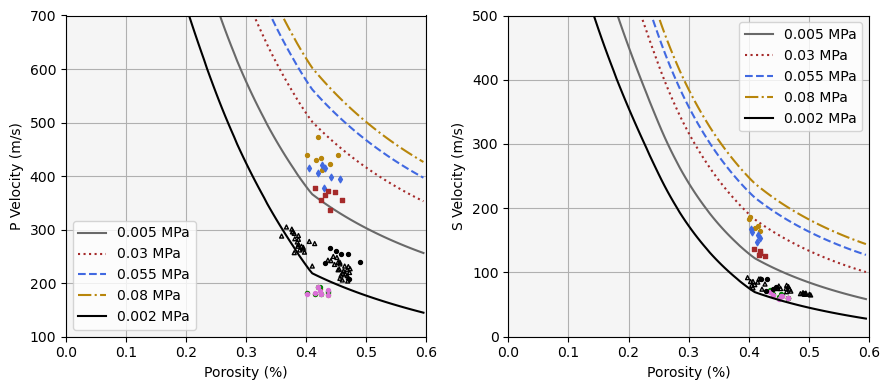

In [17]:
"""
Load P and S vacuum measurements, add to pressure-velocity plots

Note: high error expected in absolute values of vacuum velocity
measurements, so fit to model is expected to be low
"""
## Vacuum data
## Data loads as [sample number, (vp, bulk density, porosity, vacuum classifier)]
## Vacuum classifier: 0=pre vac, 1=vacuum, 2=post-vac
data_path = "../data/velocity_picks/0_ice_vp_vacuum.txt"
data_p_vacuum = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/velocity_picks/0_ice_vs_vacuum.txt"
data_s_vacuum = np.genfromtxt(data_path, skip_header=1)

prevac_p = data_p_vacuum[np.where(data_p_vacuum[:,-1]==0)]
vac_p = data_p_vacuum[np.where(data_p_vacuum[:,-1]==1)]
postvac_p = data_p_vacuum[np.where(data_p_vacuum[:,-1]==2)]
prevac_s = data_s_vacuum[np.where(data_s_vacuum[:,-1]==0)]
vac_s = data_s_vacuum[np.where(data_s_vacuum[:,-1]==1)]
postvac_s = data_s_vacuum[np.where(data_s_vacuum[:,-1]==2)]

## Confining pressure estimate for vac holder
vac_pres = 0.0000022  #in GPa
vac_poisson = pr_fit(vac_pres**(1/10))
# vac_poisson = 0.407

## Generate plots exactly as before, add vacuum scatter points
## Model Parameters
por_range = np.arange(0,critical_porosity, 0.005)

## Calculate RP models
vp_uncem = []
vs_uncem = []
vp_vac = []
vs_vac = []

for por in por_range:
    C = rp.models.upper_murphy(por)
    dens = eff_min_density*(1-por)

    tmp_vp = []
    tmp_vs = []
    for pressure, max_poisson in zip(pressures, max_poisson_list):
        keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
        keff_amos, ueff_amos = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=max_poisson,
                                           trans_por=0.41)
        tmp_vp.append(rp.elastic.p_vel(keff_amos, ueff_amos, dens)*1000)
        tmp_vs.append(rp.elastic.s_vel(ueff_amos, dens)*1000)
    vp_uncem.append(tmp_vp)
    vs_uncem.append(tmp_vs)

    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         vac_pres, c_ratio = 0.07, slip_percent = 0.)
    keff_vac, ueff_vac = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=vac_poisson,
                                           trans_por=0.41)
    vp_vac.append(rp.elastic.p_vel(keff_vac, ueff_vac, dens)*1000)
    vs_vac.append(rp.elastic.s_vel(ueff_vac, dens)*1000)

vp_uncem = np.array(vp_uncem)
vs_uncem = np.array(vs_uncem)
vp_vac = np.array(vp_vac)
vs_vac = np.array(vs_vac)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
dot_size = 8
ax[0].plot(por_range, vp_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color="dimgray", zorder=1)
ax[0].plot(por_range, vp_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color="brown", ls=":", zorder=2)
ax[0].plot(por_range, vp_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color="royalblue", ls="--", zorder=3)
ax[0].plot(por_range, vp_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color="darkgoldenrod", ls="-.", zorder=4)
ax[0].plot(por_range, vp_vac, label=str(round(vac_pres*1000,3))+" MPa", 
           color="black", zorder=5)
ax[0].scatter(pres_step_0_p[:,2], pres_step_0_p[:,0], s=dot_size, color="black", zorder=100)
ax[0].scatter(pres_step_1_p[:,2], pres_step_1_p[:,0], s=dot_size, color="brown",
              marker="s", zorder=99)
ax[0].scatter(pres_step_2_p[:,2], pres_step_2_p[:,0], s=dot_size+3, color="royalblue",
               marker="d", zorder=98)
ax[0].scatter(pres_step_3_p[:,2], pres_step_3_p[:,0], s=dot_size, color="darkgoldenrod", zorder=97)
ax[0].scatter(data_p[:,2], data_p[:,0], s=dot_size, edgecolors="black", 
              facecolors="none", marker="^", zorder=50)
ax[0].scatter(prevac_p[:,2], prevac_p[:,0], s=dot_size, color="olive")
ax[0].scatter(vac_p[:,2], vac_p[:,0], s=dot_size, color="green")
ax[0].scatter(postvac_p[:,2], postvac_p[:,0], s=dot_size, color="orchid")
ax[0].legend()
ax[0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,700),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range, vs_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", color="dimgray")
ax[1].plot(por_range, vs_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa",
           color="brown", ls=":")
ax[1].plot(por_range, vs_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color="royalblue", ls="--")
ax[1].plot(por_range, vs_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color="darkgoldenrod", ls="-.")
ax[1].plot(por_range, vs_vac, label=str(round(vac_pres*1000,3))+" MPa", 
           color="black")
ax[1].scatter(pres_step_0_s[:,2], pres_step_0_s[:,0], s=dot_size, color="black", zorder=100)
ax[1].scatter(pres_step_1_s[:,2], pres_step_1_s[:,0], s=dot_size, color="brown", 
              marker="s", zorder=99)
ax[1].scatter(pres_step_2_s[:,2], pres_step_2_s[:,0], s=dot_size+3, color="royalblue", 
               marker="d", zorder=98)
ax[1].scatter(pres_step_3_s[:,2], pres_step_3_s[:,0], s=dot_size, color="darkgoldenrod", zorder=97)
ax[1].scatter(data_s[:,2], data_s[:,0], s=dot_size, edgecolors="black", 
              facecolors="none", marker="^", zorder=50)
ax[1].scatter(prevac_s[:,2], prevac_s[:,0], s=dot_size, color="olive")
ax[1].scatter(vac_s[:,2], vac_s[:,0], s=dot_size, color="green")
ax[1].scatter(postvac_s[:,2], postvac_s[:,0], s=dot_size, color="orchid")
ax[1].legend()
ax[1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## Coordination Number

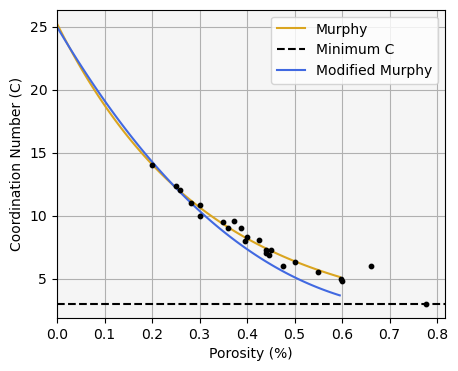

In [18]:
"""
Coordination Number

Ahmed (2018) shows how Micro-CT computed coordination numbers
are lower than the Murphy equation, however this was over more 
'standard' porosity range (i.e. <45%) Plot the upper and lower
Murphy equations over the porosity range used in this study
for investigation.

At ~40% porosity, the lower Murphy equation roughly lines up 
with coordination numbers observed by Ahmed. However, at higher 
porosity C drops below minimum C proposed by German. 

One solution: use the lower Murphy equation but set a with minimum 
C=3. This can result in sharp "kinks" in velocity/moduli with porosity.

Another solution: use Upper Murphy bound and use model fit
parameters to compensate for a likely high value for C

Plotted coordination number data from RPHandbook, pg. 233,
various sources
"""

## Perform least squares fit to coordination number data, use this to define
## the exponential fit for upper murphy
por_cn_pts = [(0.447, 6.87), (0.44, 7.25), (0.426, 8.05), (0.372, 9.57), (0.359, 9.05),
             (0.7766, 3), (0.6599, 6), (0.5969, 5), (0.4764, 6), (0.4388, 7), (0.3955, 8),
             (0.3866, 9), (0.3019, 10), (0.2817, 11), (0.2595, 12), (0.2, 14.007), 
             (0.25, 12.336), (0.3, 10.843), (0.35, 9.508), (0.4, 8.315), (0.45, 7.252),
             (0.5, 6.311), (0.55, 5.488), (0.6, 4.783)]
por_data = [i[0] for i in por_cn_pts]
cn_data = [i[1] for i in por_cn_pts]

def fit_func_cn(porosity, a, b, c):
    n = a*np.exp(b*porosity) - c
    return n

initial_guess = [24, -2.547, 0.3731]
opt_cn_parms, _ = optimize.curve_fit(fit_func_cn, por_data, cn_data, p0=initial_guess)


## Calculate coordination numbers
por_range = np.arange(0,critical_porosity, 0.005)
upper_m = []
lower_m = []
lower_m_bounded = []
mod_murphy = []
for por in por_range:
    upper_m.append(rp.models.upper_murphy(por))
    lower_m.append(rp.models.lower_murphy(por))
    lower_m_bounded.append(rp.models.lower_murphy_bounded(por))
    mod_murphy.append(rp.models.modified_murphy(por))

plt.figure(figsize=(5,4))
plt.scatter(por_data, cn_data, color="black", s=10, zorder=10)
plt.plot(por_range, upper_m, label="Murphy", c="goldenrod")
# plt.plot(por_range, lower_m, label="Lower Murphy", c="royalblue")
plt.axhline(3, linestyle="--", c='black', label="Minimum C")
# plt.plot(por_range, lower_m_bounded, ls=":", lw=4, label="Bounded Lower Murphy", c="brown")
plt.plot(por_range, mod_murphy, label="Modified Murphy", c="royalblue")
plt.gca().set(xlabel="Porosity (%)",
             ylabel="Coordination Number (C)",
             facecolor="whitesmoke",
             axisbelow=True,
             xlim=(0, None))
plt.grid("both")
plt.legend()
plt.show()

## Sample-limited "combined" dataset

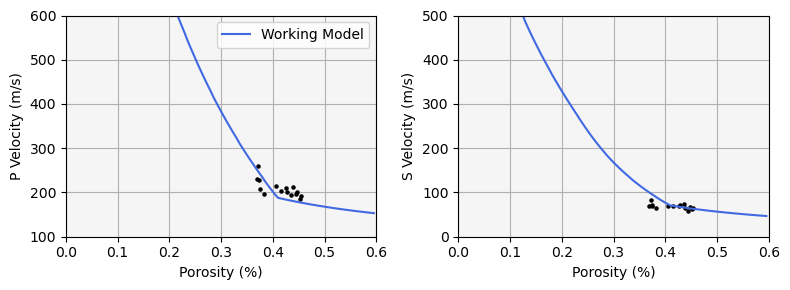

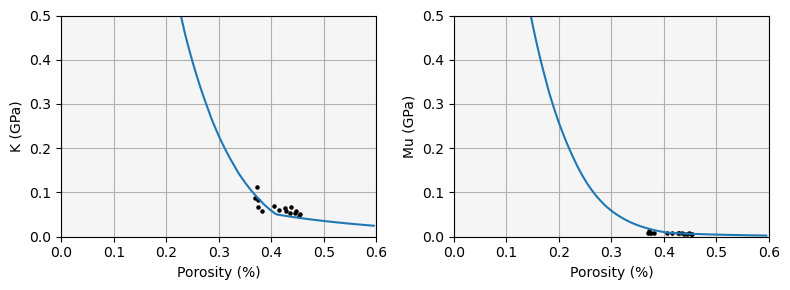

In [19]:
"""
A second sample chamber was constructed for easier transfer of the regolith sample,
allowing both P and S measurements on the exact same sample. Some sample hysteresis
is still expected. Pressure measurements could not be taken with this combined chamber,
so assume Pressure-PR relationship from above 

Initial observations are that the measured velocities are slower than those taken 
with the primary sample chamber. It is still unclear what causes this difference.

Investigate whether these slower velocities better match the observed Lunar velocities
"""

## Combined data
## Data loads as [sample number, (vp, vs, bulk density, porosity)]
data_path = "../data/velocity_picks/0_ice_combined.txt"
data_comb = np.genfromtxt(data_path, skip_header=1)


data_p_comb = data_comb[:, [0,2,3]]
data_s_comb = data_comb[:, [1,2,3]]

## Model Parameters
pressure = pressures[0]  #GPa for calculations
max_poisson_combined = 0.42  #average from measurements

## Calculate RP models, modify the model parameters used above
por_range = np.arange(0,critical_porosity, 0.005)
cr_combined = 0.1
slip_combined = 0.5


vp_amos = []
vs_amos = []
k_amos = []
mu_amos = []

for por in por_range:
    C = 3
    dens = eff_min_density*(1-por)
    
    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = cr_combined, slip_percent = slip_combined)
    keff_amos, ueff_amos = rp.models.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=max_poisson_combined, fit_por=fitting_por,
                                                   trans_por=0.41)

    vp_amos.append(rp.elastic.p_vel(keff_amos, ueff_amos, dens)*1000)
    vs_amos.append(rp.elastic.s_vel(ueff_amos, dens)*1000)
    k_amos.append(keff_amos)
    mu_amos.append(ueff_amos)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax[0].scatter(data_p_comb[:,2], data_p_comb[:,0], s=5, color="black")
ax[0].plot(por_range, vp_amos, label="Working Model", color="royalblue")
ax[0].legend()
ax[0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,600),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].scatter(data_s_comb[:,2], data_s_comb[:,0], s=5, color="black")
ax[1].plot(por_range, vs_amos, label="Working Model", color="royalblue")
# ax[1].legend()
ax[1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## CALCULATE MODULI
shear_moduli = []
for vs, dens in zip(data_s_comb[:,0], data_s_comb[:,1]):
    shear_moduli.append(rp.elastic.shear_mod(vs, dens)/1000000)
vs_fit = np.poly1d(np.polyfit(data_s_comb[:,2], data_s_comb[:,0], deg=1))  #linear fit to VS/por
bulk_moduli = []
for vp, dens, por in zip(data_p_comb[:,0], data_p_comb[:,1], data_p_comb[:,2]):
    vs = vs_fit(por)
    bulk_moduli.append(rp.elastic.bulk_mod(vp, vs, dens)/1000000)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax[0].plot(por_range,k_amos)
ax[0].scatter(data_p_comb[:,2], bulk_moduli, s=5, color="black")
ax[0].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
         xlabel="Porosity (%)",
         ylabel="K (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range,mu_amos)
ax[1].scatter(data_s_comb[:,2], shear_moduli, s=5, color="black")
ax[1].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
         xlabel="Porosity (%)",
         ylabel="Mu (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## Pressure Stabilization

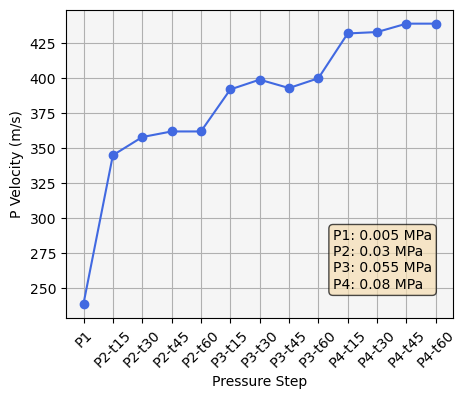

In [20]:
"""
Plot Velocity over time for pressure samples, showing how picked
velocity became stable relatively quickly after loading. This justifies
using shortened (~1 hour) stabilization times between measurements.
"""

## 3 time steps for each pressure
p_0kg = [239]
p_2kg = [345, 358, 362, 362]
p_4kg = [392, 399, 393, 400]
p_6kg = [432, 433, 439, 439]
_tmp_vels = [p_0kg, p_2kg, p_4kg, p_6kg]

## Make plot labels
_tmp_pres_labs = ["P2-", "P3-", "P4-"]
times = ["t15", "t30", "t45", "t60"]
plot_labels = ["P1"]
for _p in _tmp_pres_labs:
    for _t in times:
        plot_labels.append(_p+_t)
all_vels = [item for sublist in _tmp_vels for item in sublist]

plt.figure(figsize=(5,4))
plt.plot(all_vels, "-o", color="royalblue")
plt.gca().set(ylabel="P Velocity (m/s)",
              xlabel="Pressure Step",
             axisbelow=True,
             facecolor="whitesmoke")
plt.grid("both")
plt.xticks(np.arange(0,13,1),plot_labels, rotation=45)
overlay_text = "P1: 0.005 MPa\nP2: 0.03 MPa\nP3: 0.055 MPa\nP4: 0.08 MPa"
props = dict(boxstyle="round", facecolor="wheat", alpha=0.7)
plt.text(8.5,250,overlay_text, bbox=props)
plt.show()